# Imports

In [6]:
import numpy as np
import pandas as pd 
import sys
import itertools
from hyperopt import Trials
from hyperopt.pyll import scope
from hyperopt import hp, tpe, fmin
np.set_printoptions(threshold=sys.maxsize)
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import calculations
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
import optuna
import pickle
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
x1_train_42 = pd.read_csv('pk_60_40_training_seed42.csv')
x1_cv_42 = pd.read_csv('pk_60_40_cv_seed42.csv')
x1_et_42 = pd.read_csv('pk_60_40_et_seed42.csv')

y_train_42 = x1_train_42['AUC1']
y_cv_42 = x1_cv_42['AUC1']
y_et_42 = x1_et_42['AUC1']


del x1_train_42 ['mol']
del x1_cv_42 ['mol']
del x1_et_42 ['mol']
del x1_train_42 ['AUC1']
del x1_cv_42 ['AUC1']
del x1_et_42 ['AUC1']

In [3]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

# Scoring Files

In [4]:
etset19 = pd.read_csv('Preprocessed 19ET Set.csv')
etset19_auc = etset19 ['AUC0-5h']
del etset19 ['SMILES']
del etset19 ['Id Number']
del etset19 ['AUC0-5h']
del etset19 ['Unnamed: 0']

etset956fitpk = pd.read_csv('Preprocessed KasADockedTop1000 fit on normalizedPK.csv')
del etset956fitpk['Unnamed: 0']
id_name = etset956fitpk['MoleculeId']
del etset956fitpk['MoleculeId']
etset956fitpk_smiles = etset956fitpk['SMILES']
del etset956fitpk['SMILES']

In [5]:
def score (model, et_test_set, threshold, xtrain, ytrain):
    model.fit(xtrain, ytrain)
    probabilities = model.predict_proba(et_test_set)
    prob_1 = probabilities[:,1]
    scores = (prob_1 > threshold).astype(bool)
    scores = pd.DataFrame(scores) 
    scores.columns = ['score']
    prob_1 = pd.DataFrame (prob_1)
    prob_1.columns = ['probability']
    df = pd.concat([scores, prob_1], axis=1)
    df["score"]=df["score"].astype(int)
    return df

# Random Forest

## Space 

In [6]:
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 1000, 1), 
    'max_depth': hp.quniform('max_depth',1, 100, 1),
    'min_samples_split': hp.quniform('min_samples_split',2, 100, 1), 
    'random_state':hp.choice('random_state',[1])
    
}

## Optimizing with AUCROC 

In [59]:
def rf_aucroc42(params):
    clf_aucroc=RandomForestClassifier(n_estimators=np.int64(params['n_estimators']), 
                               max_depth=np.int64(params['max_depth']),
                               min_samples_split=np.int64(params['min_samples_split']),
                               random_state = np.int64(params['random_state']))
                               
    clf_aucroc.fit(x1_train_42, np.ravel(y_train_42))
    rocauc = roc_auc_score(y_cv_42, clf_aucroc.predict_proba(x1_cv_42)[:, 1])
    score = rocauc*-1
    return score

In [60]:
tpe_algorithm = tpe.suggest
num_eval = 2000
trials = Trials()
best_param = fmin(rf_aucroc42, space, algo=tpe.suggest, trials=trials, max_evals=num_eval, rstate=np.random.default_rng(1))
print(best_param)

100%|████| 2000/2000 [14:01<00:00,  2.38trial/s, best loss: -0.9736842105263158]
{'max_depth': 90.0, 'min_samples_split': 2.0, 'n_estimators': 66.0, 'random_state': 0}


### Results 

#### Metrics 

In [9]:
clf_aucroc = RandomForestClassifier(max_depth=90, n_estimators=66, min_samples_split = 2, random_state =1)
clf_aucroc.fit(x1_train_42, y_train_42)
best_threshold_range_rf = calculations.optimized_threshold(clf_aucroc, x1_cv_42, y_cv_42, 'range')
rf_metrics = calculations.classification_metrics(clf_aucroc, x1_cv_42, y_cv_42, x1_et_42, y_et_42, best_threshold_range_rf)
rf_metrics

,CV Set,Test Set
Threshold,0.349000,0.349000
ROC AUC,0.921053,0.868421
PR AUC,0.931818,0.898684
Balanced Accuracy,0.921053,0.868421
Sensitivity,1.000000,0.894737
Specificity,0.842105,0.842105
MCC,0.852803,0.737865
Precision,0.863636,0.850000
Recall,1.000000,0.894737
F1 Score,0.926829,0.871795


#### Confusion Matrix 

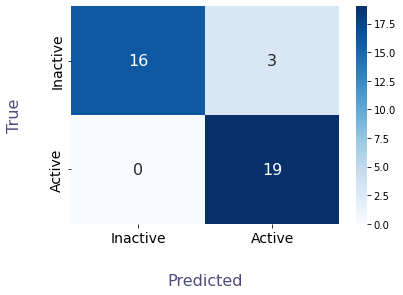

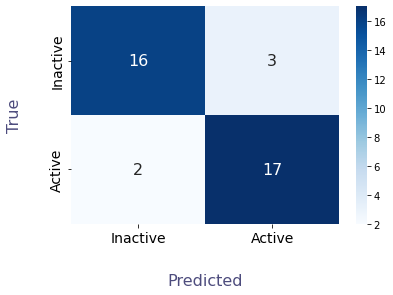

In [11]:
calculations.confusion_matrix(clf_aucroc, x1_cv_42, y_cv_42, best_threshold_range_rf),
calculations.confusion_matrix(clf_aucroc, x1_et_42, y_et_42, best_threshold_range_rf)

## Scoring

### 19 Compounds ET Set

In [118]:
score_rf19 = score(clf_aucroc, etset19, best_threshold_range_rf, x1_train_42, y_train_42)
df2 = pd.concat([etset19_auc, score_rf19], axis = 1)
df2

/Users/khadijamughal/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


,AUC0-5h,score,probability
0,921.0,1,0.484848
1,3.0,1,0.409091
2,3.0,1,0.378788
3,2393.0,1,0.409091
4,616.0,1,0.545455
5,25001.0,1,0.545455
6,9105.0,1,0.454545
7,754.0,1,0.545455
8,10399.0,1,0.454545
9,135.0,1,0.500000


### 956 Compounds 

In [20]:
score_rf956_2 = score(clf_aucroc, etset956fitpk, best_threshold_range_rf, x1_train_42, y_train_42)
count_rfscore2 = score_rf956_2['score'].value_counts()
count_rfscore2

/Users/khadijamughal/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


0    644
1    312
Name: score, dtype: int64

In [22]:
scores_rf = pd.concat([etset956fitpk_smiles, id_name, score_rf956_2], axis = 1)
scores_rf = scores_rf.sort_values(['probability'], ascending = False)
scores_rf

,SMILES,MoleculeId,score,probability
133,FC(F)(F)c1cc(C2(c3oc(Cc4cc5c(cc4)cccc5)nn3)CCO...,Z1166113062,1,0.439394
219,FC(F)(F)c1ccc(CN2CCN(C(=O)C3CCN(C(=O)c4ccc(F)c...,Z131360162,1,0.424242
605,O=C(CONC(=O)c1ccccc1)N1C(c2ccccc2)C2C(C(=Cc3cc...,Z25686808,1,0.424242
398,Clc1ccc(S(=O)(=O)N2c3nc4c(nc3N(c3cc(C(F)(F)F)c...,Z56775413,1,0.424242
132,Clc1cc2nc(O)c(c(-c3ccccc3)c2cc1)-c1nc2c(c(-c3c...,Z2010009645,1,0.409091
...,...,...,...,...
433,O=C(NC(c1cc2nc[nH]c2cc1)c1ccccc1)CC1C(=O)Nc2c(...,Z237721938,0,0.272727
358,S(=O)(=O)(N1CCN(C(=O)c2cc3NC(=O)CSc3cc2)CC1)c1...,Z29402494,0,0.272727
718,Clc1c(C(=O)n2nc(N)c3c2cccc3)cc(S(=O)(=O)Nc2cc(...,Z381337772,0,0.272727
445,FC(F)(F)c1cc2NC(=O)C(CC(=O)NC(c3oc4c(c3)cccc4)...,Z200589384,0,0.272727


# XGBoost

In [12]:
space3 = {
    'n_estimators': hp.quniform('n_estimators', 50, 1000, 1), 
    'max_depth': hp.quniform('max_depth',1, 100, 1),
    'min_child_weight':hp.quniform('min_child_weight', 0, 1, 0.2),
    'random_state':hp.choice('random_state',[1])
    
}

## Optuna 2 

In [4]:
def objective_xgb2 (trial):
    param={
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth',5, 20),
        'min_child_weight': trial.suggest_float('min_child_weight',0.1, 1),
        'learning_rate':trial.suggest_float('learning_rate',0.001,0.01),
        'subsample':trial.suggest_float('subsample', 0.1, 1),
        'random_state':1
    }
    
    xgb_optuna1 = XGBClassifier(**param)
    xgb_optuna1.fit(x1_train_42, y_train_42, eval_metric = 'auc')
    rocauc = roc_auc_score(y_cv_42, xgb_optuna1.predict_proba(x1_cv_42)[:, 1])
    return rocauc

In [5]:
study4 = optuna.create_study(direction = 'maximize')
study4.optimize(objective_xgb2, n_trials = 2000)
trial4 = study4.best_trial

[I 2023-02-07 16:55:13,873] A new study created in memory with name: no-name-cad77b7e-8b2c-4750-8a72-bdd50ddb228c
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 16:55:15,033] Trial 0 finished with value: 0.9113573407202216 and parameters: {'n_estimators': 183, 'max_depth': 16, 'min_child_weight': 0.7262939100258056, 'learning_rate': 0.0073254541309064145, 'subsample': 0.3315003241759768}. Best is trial 0 with value: 0.9113573407202216.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is d

[I 2023-02-07 16:55:36,381] Trial 10 finished with value: 0.9168975069252078 and parameters: {'n_estimators': 475, 'max_depth': 5, 'min_child_weight': 0.9629072469281211, 'learning_rate': 0.009998230664300637, 'subsample': 0.5434429617055687}. Best is trial 4 with value: 0.9307479224376731.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 16:55:37,277] Trial 11 finished with value: 0.925207756232687 and parameters: {'n_estimators': 113, 'max_depth': 15, 'min_child_weight': 0.9872067041423191, 'learning_rate': 0.005016444777119981, 'subsample': 0.49478455084275635}. Bes

[I 2023-02-07 16:56:00,455] Trial 21 finished with value: 0.9196675900277008 and parameters: {'n_estimators': 424, 'max_depth': 18, 'min_child_weight': 0.6069547543244572, 'learning_rate': 0.00767421453868556, 'subsample': 0.3959796723296623}. Best is trial 4 with value: 0.9307479224376731.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 16:56:02,893] Trial 22 finished with value: 0.9196675900277008 and parameters: {'n_estimators': 387, 'max_depth': 18, 'min_child_weight': 0.6727221750578277, 'learning_rate': 0.006323744056590775, 'subsample': 0.3996919619170359}. Bes

[I 2023-02-07 16:56:33,286] Trial 32 finished with value: 0.9196675900277008 and parameters: {'n_estimators': 500, 'max_depth': 11, 'min_child_weight': 0.7679551696585974, 'learning_rate': 0.006592480667121651, 'subsample': 0.48614222940794}. Best is trial 31 with value: 0.9418282548476453.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 16:56:36,551] Trial 33 finished with value: 0.9141274238227146 and parameters: {'n_estimators': 466, 'max_depth': 10, 'min_child_weight': 0.7640259925772602, 'learning_rate': 0.005655985433582655, 'subsample': 0.5285762566672184}. Bes

[I 2023-02-07 16:57:00,507] Trial 43 finished with value: 0.9418282548476453 and parameters: {'n_estimators': 479, 'max_depth': 16, 'min_child_weight': 0.7466995504988149, 'learning_rate': 0.007141486453012462, 'subsample': 0.45851146767906664}. Best is trial 31 with value: 0.9418282548476453.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 16:57:02,733] Trial 44 finished with value: 0.9362880886426592 and parameters: {'n_estimators': 471, 'max_depth': 16, 'min_child_weight': 0.818369717154831, 'learning_rate': 0.006917303946313088, 'subsample': 0.37055575977305577}. 

[I 2023-02-07 16:57:29,027] Trial 54 finished with value: 0.925207756232687 and parameters: {'n_estimators': 415, 'max_depth': 13, 'min_child_weight': 0.8637939682705837, 'learning_rate': 0.007803703787427288, 'subsample': 0.5191440045341648}. Best is trial 31 with value: 0.9418282548476453.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 16:57:30,853] Trial 55 finished with value: 0.9362880886426593 and parameters: {'n_estimators': 283, 'max_depth': 12, 'min_child_weight': 0.7945113879515876, 'learning_rate': 0.007110326328726247, 'subsample': 0.4772325497861623}. Be

[I 2023-02-07 16:57:50,320] Trial 65 finished with value: 0.9168975069252077 and parameters: {'n_estimators': 316, 'max_depth': 11, 'min_child_weight': 0.8389371357639867, 'learning_rate': 0.007957201737467353, 'subsample': 0.5101070019462122}. Best is trial 31 with value: 0.9418282548476453.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 16:57:52,578] Trial 66 finished with value: 0.9196675900277008 and parameters: {'n_estimators': 465, 'max_depth': 9, 'min_child_weight': 0.7029889127603002, 'learning_rate': 0.006336312654346328, 'subsample': 0.3625484565027527}. Be

[I 2023-02-07 16:58:16,218] Trial 76 finished with value: 0.9335180055401662 and parameters: {'n_estimators': 450, 'max_depth': 10, 'min_child_weight': 0.826912974209393, 'learning_rate': 0.0074604264194613355, 'subsample': 0.46155429280417537}. Best is trial 67 with value: 0.9418282548476454.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 16:58:19,139] Trial 77 finished with value: 0.9279778393351801 and parameters: {'n_estimators': 487, 'max_depth': 11, 'min_child_weight': 0.7800751493383051, 'learning_rate': 0.007239867445953905, 'subsample': 0.3981289070857583}. 

[I 2023-02-07 16:58:45,809] Trial 87 finished with value: 0.9279778393351801 and parameters: {'n_estimators': 477, 'max_depth': 12, 'min_child_weight': 0.7148078255394499, 'learning_rate': 0.006705522511279078, 'subsample': 0.36272991898665113}. Best is trial 67 with value: 0.9418282548476454.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 16:58:48,372] Trial 88 finished with value: 0.9279778393351801 and parameters: {'n_estimators': 413, 'max_depth': 9, 'min_child_weight': 0.7725343531559278, 'learning_rate': 0.0070241505056572485, 'subsample': 0.4492632101734936}. 

[I 2023-02-07 16:59:15,639] Trial 98 finished with value: 0.9335180055401662 and parameters: {'n_estimators': 478, 'max_depth': 15, 'min_child_weight': 0.7149936930554148, 'learning_rate': 0.006408268567452245, 'subsample': 0.41387524309521573}. Best is trial 67 with value: 0.9418282548476454.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 16:59:18,175] Trial 99 finished with value: 0.9168975069252078 and parameters: {'n_estimators': 493, 'max_depth': 14, 'min_child_weight': 0.7713361668541323, 'learning_rate': 0.007113878255074555, 'subsample': 0.5174086445695714}. 

[I 2023-02-07 16:59:46,800] Trial 109 finished with value: 0.9390581717451524 and parameters: {'n_estimators': 494, 'max_depth': 12, 'min_child_weight': 0.9107676095692592, 'learning_rate': 0.007477471301467013, 'subsample': 0.4547438297610774}. Best is trial 100 with value: 0.9445983379501384.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 16:59:50,038] Trial 110 finished with value: 0.925207756232687 and parameters: {'n_estimators': 494, 'max_depth': 9, 'min_child_weight': 0.9094133713841959, 'learning_rate': 0.006723092669402582, 'subsample': 0.38699625859116393}.

[I 2023-02-07 17:00:18,404] Trial 120 finished with value: 0.92797783933518 and parameters: {'n_estimators': 475, 'max_depth': 13, 'min_child_weight': 0.8394422365063999, 'learning_rate': 0.006423791612900253, 'subsample': 0.3726037365641116}. Best is trial 100 with value: 0.9445983379501384.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:00:20,801] Trial 121 finished with value: 0.9335180055401662 and parameters: {'n_estimators': 491, 'max_depth': 12, 'min_child_weight': 0.8202063906491629, 'learning_rate': 0.007184942113951566, 'subsample': 0.4617653644820487}. 

[I 2023-02-07 17:00:47,929] Trial 131 finished with value: 0.9362880886426592 and parameters: {'n_estimators': 491, 'max_depth': 12, 'min_child_weight': 0.7849498811103118, 'learning_rate': 0.00759760630487468, 'subsample': 0.4759866061334393}. Best is trial 100 with value: 0.9445983379501384.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:00:50,902] Trial 132 finished with value: 0.9335180055401662 and parameters: {'n_estimators': 481, 'max_depth': 12, 'min_child_weight': 0.8037755498355479, 'learning_rate': 0.007001112341044537, 'subsample': 0.42836819532323883}

[I 2023-02-07 17:01:18,117] Trial 142 finished with value: 0.9390581717451523 and parameters: {'n_estimators': 459, 'max_depth': 18, 'min_child_weight': 0.8120229965782214, 'learning_rate': 0.007288683325276507, 'subsample': 0.45811889367631226}. Best is trial 139 with value: 0.9445983379501385.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:01:20,900] Trial 143 finished with value: 0.925207756232687 and parameters: {'n_estimators': 468, 'max_depth': 18, 'min_child_weight': 0.8911193423760353, 'learning_rate': 0.008111728833531163, 'subsample': 0.40414421176486937

[I 2023-02-07 17:01:49,052] Trial 153 finished with value: 0.925207756232687 and parameters: {'n_estimators': 485, 'max_depth': 18, 'min_child_weight': 0.8082790880888326, 'learning_rate': 0.007287811680861016, 'subsample': 0.4175893649628049}. Best is trial 139 with value: 0.9445983379501385.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:01:51,958] Trial 154 finished with value: 0.9279778393351801 and parameters: {'n_estimators': 461, 'max_depth': 17, 'min_child_weight': 0.7282336171621712, 'learning_rate': 0.006424011539362151, 'subsample': 0.4801013989626727}.

[I 2023-02-07 17:02:21,211] Trial 164 finished with value: 0.9362880886426593 and parameters: {'n_estimators': 462, 'max_depth': 17, 'min_child_weight': 0.80213676266428, 'learning_rate': 0.007084409556753282, 'subsample': 0.4706148852863726}. Best is trial 139 with value: 0.9445983379501385.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:02:24,004] Trial 165 finished with value: 0.9279778393351801 and parameters: {'n_estimators': 486, 'max_depth': 17, 'min_child_weight': 0.820525192747866, 'learning_rate': 0.006193976720927278, 'subsample': 0.4227646670333044}. B

[I 2023-02-07 17:02:52,174] Trial 175 finished with value: 0.9362880886426593 and parameters: {'n_estimators': 486, 'max_depth': 16, 'min_child_weight': 0.8360360897521139, 'learning_rate': 0.007391064566177694, 'subsample': 0.4774196510634224}. Best is trial 139 with value: 0.9445983379501385.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:02:55,146] Trial 176 finished with value: 0.9335180055401662 and parameters: {'n_estimators': 500, 'max_depth': 12, 'min_child_weight': 0.818162051460032, 'learning_rate': 0.006786925798843863, 'subsample': 0.44815286078614697}

[I 2023-02-07 17:03:22,382] Trial 186 finished with value: 0.925207756232687 and parameters: {'n_estimators': 475, 'max_depth': 10, 'min_child_weight': 0.8111520726044045, 'learning_rate': 0.0072210602388492005, 'subsample': 0.3924067341068305}. Best is trial 139 with value: 0.9445983379501385.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:03:25,309] Trial 187 finished with value: 0.9335180055401662 and parameters: {'n_estimators': 487, 'max_depth': 12, 'min_child_weight': 0.8484401545053277, 'learning_rate': 0.00577805545381546, 'subsample': 0.44764690309135774}

[I 2023-02-07 17:03:50,137] Trial 197 finished with value: 0.9168975069252078 and parameters: {'n_estimators': 500, 'max_depth': 13, 'min_child_weight': 0.7514268884745217, 'learning_rate': 0.007640514603389137, 'subsample': 0.5114068557455885}. Best is trial 139 with value: 0.9445983379501385.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:03:52,474] Trial 198 finished with value: 0.9418282548476455 and parameters: {'n_estimators': 483, 'max_depth': 12, 'min_child_weight': 0.8072108865456171, 'learning_rate': 0.007372904287752254, 'subsample': 0.4558684151148041}

[I 2023-02-07 17:04:16,220] Trial 208 finished with value: 0.9224376731301939 and parameters: {'n_estimators': 307, 'max_depth': 12, 'min_child_weight': 0.6011197623061586, 'learning_rate': 0.007506722184835767, 'subsample': 0.4356231416350742}. Best is trial 139 with value: 0.9445983379501385.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:04:18,607] Trial 209 finished with value: 0.9335180055401662 and parameters: {'n_estimators': 478, 'max_depth': 7, 'min_child_weight': 0.7531672216716848, 'learning_rate': 0.007058625866939898, 'subsample': 0.44757982770272176}

[I 2023-02-07 17:04:43,397] Trial 219 finished with value: 0.9390581717451524 and parameters: {'n_estimators': 482, 'max_depth': 10, 'min_child_weight': 0.6323984643767685, 'learning_rate': 0.005526686094678799, 'subsample': 0.4615397015143473}. Best is trial 139 with value: 0.9445983379501385.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:04:45,764] Trial 220 finished with value: 0.9113573407202216 and parameters: {'n_estimators': 488, 'max_depth': 5, 'min_child_weight': 0.8479587552947032, 'learning_rate': 0.007593944149774357, 'subsample': 0.39472091285764566}

[I 2023-02-07 17:05:09,735] Trial 230 finished with value: 0.9307479224376731 and parameters: {'n_estimators': 472, 'max_depth': 11, 'min_child_weight': 0.8514697906861214, 'learning_rate': 0.006703145321729768, 'subsample': 0.42752567411005465}. Best is trial 139 with value: 0.9445983379501385.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:05:12,090] Trial 231 finished with value: 0.9445983379501384 and parameters: {'n_estimators': 478, 'max_depth': 16, 'min_child_weight': 0.8943601913340363, 'learning_rate': 0.006650482890869502, 'subsample': 0.4421538752293278

[I 2023-02-07 17:05:36,199] Trial 241 finished with value: 0.9473684210526316 and parameters: {'n_estimators': 467, 'max_depth': 12, 'min_child_weight': 0.36571791470895554, 'learning_rate': 0.008033236599502306, 'subsample': 0.4524996611993239}. Best is trial 241 with value: 0.9473684210526316.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:05:38,570] Trial 242 finished with value: 0.9390581717451523 and parameters: {'n_estimators': 457, 'max_depth': 12, 'min_child_weight': 0.4682832793723919, 'learning_rate': 0.008308603116066599, 'subsample': 0.4537344231730620

[I 2023-02-07 17:06:03,956] Trial 252 finished with value: 0.8448753462603878 and parameters: {'n_estimators': 494, 'max_depth': 10, 'min_child_weight': 0.773509603712949, 'learning_rate': 0.0013095839162721905, 'subsample': 0.982113394602234}. Best is trial 241 with value: 0.9473684210526316.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:06:05,444] Trial 253 finished with value: 0.9224376731301939 and parameters: {'n_estimators': 261, 'max_depth': 12, 'min_child_weight': 0.6812653313456587, 'learning_rate': 0.00852797148059101, 'subsample': 0.4376473264875083}. 

[I 2023-02-07 17:06:30,532] Trial 263 finished with value: 0.9168975069252077 and parameters: {'n_estimators': 453, 'max_depth': 19, 'min_child_weight': 0.8242933931628083, 'learning_rate': 0.007919173109183551, 'subsample': 0.48299440518838604}. Best is trial 241 with value: 0.9473684210526316.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:06:33,042] Trial 264 finished with value: 0.9390581717451524 and parameters: {'n_estimators': 494, 'max_depth': 19, 'min_child_weight': 0.6314363028410708, 'learning_rate': 0.007650630396558565, 'subsample': 0.4549491993814730

[I 2023-02-07 17:06:57,728] Trial 274 finished with value: 0.9279778393351801 and parameters: {'n_estimators': 491, 'max_depth': 9, 'min_child_weight': 0.5301457418099953, 'learning_rate': 0.0075098079398034125, 'subsample': 0.4298664030564375}. Best is trial 241 with value: 0.9473684210526316.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:06:59,402] Trial 275 finished with value: 0.9390581717451523 and parameters: {'n_estimators': 209, 'max_depth': 11, 'min_child_weight': 0.626098854178999, 'learning_rate': 0.008191790493395157, 'subsample': 0.4637876482770246}.

[I 2023-02-07 17:07:24,247] Trial 285 finished with value: 0.9224376731301939 and parameters: {'n_estimators': 486, 'max_depth': 12, 'min_child_weight': 0.9492673423586151, 'learning_rate': 0.007385802155760177, 'subsample': 0.5920772671124321}. Best is trial 241 with value: 0.9473684210526316.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:07:26,569] Trial 286 finished with value: 0.9362880886426592 and parameters: {'n_estimators': 469, 'max_depth': 13, 'min_child_weight': 0.9243524295797536, 'learning_rate': 0.004859982312161084, 'subsample': 0.45024415313526295

[I 2023-02-07 17:07:50,083] Trial 296 finished with value: 0.925207756232687 and parameters: {'n_estimators': 461, 'max_depth': 10, 'min_child_weight': 0.5054082552270732, 'learning_rate': 0.006505213830470677, 'subsample': 0.5110450468911539}. Best is trial 241 with value: 0.9473684210526316.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:07:52,450] Trial 297 finished with value: 0.925207756232687 and parameters: {'n_estimators': 445, 'max_depth': 10, 'min_child_weight': 0.6051589877269618, 'learning_rate': 0.006320926803693476, 'subsample': 0.46591614936181336}.

[I 2023-02-07 17:08:15,693] Trial 307 finished with value: 0.9362880886426592 and parameters: {'n_estimators': 476, 'max_depth': 9, 'min_child_weight': 0.7786311481869603, 'learning_rate': 0.005606682108941479, 'subsample': 0.4400695084911062}. Best is trial 241 with value: 0.9473684210526316.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:08:18,215] Trial 308 finished with value: 0.9445983379501385 and parameters: {'n_estimators': 486, 'max_depth': 11, 'min_child_weight': 0.4469363311881126, 'learning_rate': 0.005969345781652497, 'subsample': 0.4561913391921997}.

[I 2023-02-07 17:08:40,001] Trial 318 finished with value: 0.9335180055401662 and parameters: {'n_estimators': 461, 'max_depth': 11, 'min_child_weight': 0.47932852155072875, 'learning_rate': 0.005902158466147164, 'subsample': 0.45009379018277185}. Best is trial 241 with value: 0.9473684210526316.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:08:42,482] Trial 319 finished with value: 0.9418282548476454 and parameters: {'n_estimators': 500, 'max_depth': 10, 'min_child_weight': 0.7945536017647743, 'learning_rate': 0.007510785657080855, 'subsample': 0.471890498979092

[I 2023-02-07 17:09:04,976] Trial 329 finished with value: 0.9196675900277008 and parameters: {'n_estimators': 471, 'max_depth': 10, 'min_child_weight': 0.7671995983724265, 'learning_rate': 0.00738864606112584, 'subsample': 0.5129348952103021}. Best is trial 241 with value: 0.9473684210526316.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:09:07,332] Trial 330 finished with value: 0.9335180055401662 and parameters: {'n_estimators': 454, 'max_depth': 12, 'min_child_weight': 0.4031150180826067, 'learning_rate': 0.007199466804583006, 'subsample': 0.4249668806321069}.

[I 2023-02-07 17:09:32,664] Trial 340 finished with value: 0.9473684210526316 and parameters: {'n_estimators': 472, 'max_depth': 11, 'min_child_weight': 0.7802392104512217, 'learning_rate': 0.007952293289590795, 'subsample': 0.459325250686751}. Best is trial 241 with value: 0.9473684210526316.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:09:35,081] Trial 341 finished with value: 0.9307479224376731 and parameters: {'n_estimators': 471, 'max_depth': 11, 'min_child_weight': 0.7737799762535235, 'learning_rate': 0.00810032932342791, 'subsample': 0.48000721693348}. Be

[I 2023-02-07 17:10:00,020] Trial 351 finished with value: 0.9362880886426592 and parameters: {'n_estimators': 450, 'max_depth': 12, 'min_child_weight': 0.5026898225559758, 'learning_rate': 0.007806355806984503, 'subsample': 0.44292862085015167}. Best is trial 241 with value: 0.9473684210526316.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:10:02,485] Trial 352 finished with value: 0.9168975069252077 and parameters: {'n_estimators': 468, 'max_depth': 12, 'min_child_weight': 0.45357530722002093, 'learning_rate': 0.007628702221659836, 'subsample': 0.411062758035134

[I 2023-02-07 17:10:26,611] Trial 362 finished with value: 0.9335180055401663 and parameters: {'n_estimators': 455, 'max_depth': 13, 'min_child_weight': 0.45337767599218803, 'learning_rate': 0.007343240454529856, 'subsample': 0.5479412199108001}. Best is trial 241 with value: 0.9473684210526316.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:10:29,990] Trial 363 finished with value: 0.9224376731301939 and parameters: {'n_estimators': 474, 'max_depth': 18, 'min_child_weight': 0.48013875725985616, 'learning_rate': 0.007841025265672378, 'subsample': 0.508213609606146

[I 2023-02-07 17:10:55,433] Trial 373 finished with value: 0.9113573407202216 and parameters: {'n_estimators': 101, 'max_depth': 11, 'min_child_weight': 0.9359662945302887, 'learning_rate': 0.006049769444722622, 'subsample': 0.355827368014618}. Best is trial 241 with value: 0.9473684210526316.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:10:58,127] Trial 374 finished with value: 0.9196675900277008 and parameters: {'n_estimators': 464, 'max_depth': 12, 'min_child_weight': 0.3442757288105456, 'learning_rate': 0.00762923085387929, 'subsample': 0.40378761526515305}.

[I 2023-02-07 17:11:23,748] Trial 384 finished with value: 0.9307479224376731 and parameters: {'n_estimators': 371, 'max_depth': 14, 'min_child_weight': 0.3777168191003556, 'learning_rate': 0.0077337142446161945, 'subsample': 0.3900452939638552}. Best is trial 241 with value: 0.9473684210526316.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:11:26,198] Trial 385 finished with value: 0.9307479224376731 and parameters: {'n_estimators': 470, 'max_depth': 12, 'min_child_weight': 0.3986070406043763, 'learning_rate': 0.0046392457494924995, 'subsample': 0.437574557979976

[I 2023-02-07 17:11:52,998] Trial 395 finished with value: 0.925207756232687 and parameters: {'n_estimators': 452, 'max_depth': 12, 'min_child_weight': 0.5095205883426149, 'learning_rate': 0.00784520153406903, 'subsample': 0.4003289447997252}. Best is trial 241 with value: 0.9473684210526316.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:11:55,469] Trial 396 finished with value: 0.9307479224376731 and parameters: {'n_estimators': 493, 'max_depth': 17, 'min_child_weight': 0.4630644407950836, 'learning_rate': 0.007083572926389218, 'subsample': 0.37527975797081414}.

[I 2023-02-07 17:12:23,472] Trial 406 finished with value: 0.9362880886426592 and parameters: {'n_estimators': 482, 'max_depth': 11, 'min_child_weight': 0.7905541887455146, 'learning_rate': 0.007207588364718296, 'subsample': 0.4501813860315461}. Best is trial 241 with value: 0.9473684210526316.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:12:26,505] Trial 407 finished with value: 0.922437673130194 and parameters: {'n_estimators': 500, 'max_depth': 10, 'min_child_weight': 0.6103953060287439, 'learning_rate': 0.0014504298292968322, 'subsample': 0.414291514269021}.

[I 2023-02-07 17:12:54,650] Trial 417 finished with value: 0.9252077562326869 and parameters: {'n_estimators': 494, 'max_depth': 10, 'min_child_weight': 0.5704140708037021, 'learning_rate': 0.008586839134841871, 'subsample': 0.5446393355032354}. Best is trial 241 with value: 0.9473684210526316.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:12:57,126] Trial 418 finished with value: 0.9279778393351801 and parameters: {'n_estimators': 480, 'max_depth': 11, 'min_child_weight': 0.44237332800783513, 'learning_rate': 0.00826687270992852, 'subsample': 0.4010812269300596}

[I 2023-02-07 17:13:21,727] Trial 428 finished with value: 0.9362880886426593 and parameters: {'n_estimators': 481, 'max_depth': 14, 'min_child_weight': 0.9517498292799043, 'learning_rate': 0.007848774818555388, 'subsample': 0.45433654517001}. Best is trial 241 with value: 0.9473684210526316.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:13:24,206] Trial 429 finished with value: 0.9307479224376732 and parameters: {'n_estimators': 494, 'max_depth': 18, 'min_child_weight': 0.544673998778949, 'learning_rate': 0.0067362855799458915, 'subsample': 0.4096016922414216}. 

[I 2023-02-07 17:13:49,453] Trial 439 finished with value: 0.9473684210526316 and parameters: {'n_estimators': 487, 'max_depth': 13, 'min_child_weight': 0.3694047396783922, 'learning_rate': 0.007677640918732126, 'subsample': 0.45626062226494435}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:13:52,072] Trial 440 finished with value: 0.9473684210526316 and parameters: {'n_estimators': 488, 'max_depth': 13, 'min_child_weight': 0.3738856017265683, 'learning_rate': 0.0076166639965567625, 'subsample': 0.453093677725161

[I 2023-02-07 17:14:23,390] Trial 450 finished with value: 0.9445983379501386 and parameters: {'n_estimators': 500, 'max_depth': 14, 'min_child_weight': 0.34210475139501456, 'learning_rate': 0.008330146932910652, 'subsample': 0.45457256978607746}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:14:26,824] Trial 451 finished with value: 0.92797783933518 and parameters: {'n_estimators': 498, 'max_depth': 14, 'min_child_weight': 0.3271734347362443, 'learning_rate': 0.00833688520293153, 'subsample': 0.4833982047430556}.

[I 2023-02-07 17:14:53,061] Trial 461 finished with value: 0.9335180055401662 and parameters: {'n_estimators': 488, 'max_depth': 14, 'min_child_weight': 0.32533492113901796, 'learning_rate': 0.00854251845911053, 'subsample': 0.4127881409878508}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:14:56,030] Trial 462 finished with value: 0.9307479224376731 and parameters: {'n_estimators': 487, 'max_depth': 14, 'min_child_weight': 0.365885419291536, 'learning_rate': 0.007993192137238307, 'subsample': 0.3550269575301149}.

[I 2023-02-07 17:15:22,423] Trial 472 finished with value: 0.9002770083102493 and parameters: {'n_estimators': 494, 'max_depth': 14, 'min_child_weight': 0.3886970746647307, 'learning_rate': 0.008321361505366453, 'subsample': 0.9047222271767071}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:15:24,904] Trial 473 finished with value: 0.92797783933518 and parameters: {'n_estimators': 492, 'max_depth': 14, 'min_child_weight': 0.36786919131380486, 'learning_rate': 0.008433711778036215, 'subsample': 0.3955110124474236}.

[I 2023-02-07 17:15:52,130] Trial 483 finished with value: 0.9418282548476454 and parameters: {'n_estimators': 488, 'max_depth': 14, 'min_child_weight': 0.34068781684144567, 'learning_rate': 0.008090514905758375, 'subsample': 0.3809454054332794}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:15:54,735] Trial 484 finished with value: 0.9390581717451524 and parameters: {'n_estimators': 492, 'max_depth': 14, 'min_child_weight': 0.3189616582393673, 'learning_rate': 0.008224863779181106, 'subsample': 0.4207408233113347

[I 2023-02-07 17:16:20,974] Trial 494 finished with value: 0.9418282548476454 and parameters: {'n_estimators': 500, 'max_depth': 14, 'min_child_weight': 0.2793491157266006, 'learning_rate': 0.008082033426680669, 'subsample': 0.3796784381711518}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:16:23,949] Trial 495 finished with value: 0.9335180055401662 and parameters: {'n_estimators': 500, 'max_depth': 14, 'min_child_weight': 0.30072605900362875, 'learning_rate': 0.00793864741075051, 'subsample': 0.3695584418658954}

[I 2023-02-07 17:16:49,635] Trial 505 finished with value: 0.9113573407202216 and parameters: {'n_estimators': 495, 'max_depth': 14, 'min_child_weight': 0.32993630876435337, 'learning_rate': 0.007829964833312678, 'subsample': 0.7705413913451323}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:16:52,117] Trial 506 finished with value: 0.9390581717451523 and parameters: {'n_estimators': 484, 'max_depth': 13, 'min_child_weight': 0.2993771043361881, 'learning_rate': 0.008427238758711585, 'subsample': 0.3896384128667953

[I 2023-02-07 17:17:18,399] Trial 516 finished with value: 0.930747922437673 and parameters: {'n_estimators': 481, 'max_depth': 13, 'min_child_weight': 0.3798692180436446, 'learning_rate': 0.007716636108016143, 'subsample': 0.4731559097604249}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:17:20,904] Trial 517 finished with value: 0.9196675900277008 and parameters: {'n_estimators': 500, 'max_depth': 14, 'min_child_weight': 0.32717144314458807, 'learning_rate': 0.00831312983699383, 'subsample': 0.32084070422661704}

[I 2023-02-07 17:17:50,232] Trial 527 finished with value: 0.92797783933518 and parameters: {'n_estimators': 493, 'max_depth': 13, 'min_child_weight': 0.40409017015575965, 'learning_rate': 0.005292626330630263, 'subsample': 0.5256341452408131}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:17:53,449] Trial 528 finished with value: 0.930747922437673 and parameters: {'n_estimators': 493, 'max_depth': 13, 'min_child_weight': 0.4161444900517539, 'learning_rate': 0.004811803262550974, 'subsample': 0.48685071941248936}.

[I 2023-02-07 17:18:21,273] Trial 538 finished with value: 0.9058171745152355 and parameters: {'n_estimators': 189, 'max_depth': 14, 'min_child_weight': 0.3208588471224021, 'learning_rate': 0.009795817584902613, 'subsample': 0.4318122510609083}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:18:23,864] Trial 539 finished with value: 0.930747922437673 and parameters: {'n_estimators': 496, 'max_depth': 15, 'min_child_weight': 0.24179183334786952, 'learning_rate': 0.008975600983655343, 'subsample': 0.3971004264336113}

[I 2023-02-07 17:18:48,145] Trial 549 finished with value: 0.9418282548476454 and parameters: {'n_estimators': 478, 'max_depth': 14, 'min_child_weight': 0.27644555278869487, 'learning_rate': 0.009613585253402822, 'subsample': 0.4400824949317147}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:18:50,557] Trial 550 finished with value: 0.92797783933518 and parameters: {'n_estimators': 478, 'max_depth': 14, 'min_child_weight': 0.29613487145013634, 'learning_rate': 0.009767302833271518, 'subsample': 0.3982829963966656}

[I 2023-02-07 17:19:16,973] Trial 560 finished with value: 0.9224376731301939 and parameters: {'n_estimators': 486, 'max_depth': 15, 'min_child_weight': 0.3282687898566107, 'learning_rate': 0.00999314726272931, 'subsample': 0.6616641429362362}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:19:19,801] Trial 561 finished with value: 0.9113573407202216 and parameters: {'n_estimators': 476, 'max_depth': 14, 'min_child_weight': 0.30948951652886175, 'learning_rate': 0.008801857094639959, 'subsample': 0.7723661228545496}

[I 2023-02-07 17:19:42,607] Trial 571 finished with value: 0.9168975069252078 and parameters: {'n_estimators': 211, 'max_depth': 14, 'min_child_weight': 0.35286681172723044, 'learning_rate': 0.009773905548038525, 'subsample': 0.41957161772614915}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:19:45,516] Trial 572 finished with value: 0.9224376731301939 and parameters: {'n_estimators': 487, 'max_depth': 13, 'min_child_weight': 0.2735347739235341, 'learning_rate': 0.009124313983464137, 'subsample': 0.289980461606493

[I 2023-02-07 17:20:11,693] Trial 582 finished with value: 0.9085872576177285 and parameters: {'n_estimators': 268, 'max_depth': 15, 'min_child_weight': 0.3273359560373537, 'learning_rate': 0.009693716265727908, 'subsample': 0.8598438189667336}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:20:14,545] Trial 583 finished with value: 0.9335180055401662 and parameters: {'n_estimators': 492, 'max_depth': 13, 'min_child_weight': 0.3880960921948422, 'learning_rate': 0.009621772590983242, 'subsample': 0.5298849499732864}

[I 2023-02-07 17:20:41,659] Trial 593 finished with value: 0.9113573407202216 and parameters: {'n_estimators': 420, 'max_depth': 13, 'min_child_weight': 0.3205232645413069, 'learning_rate': 0.008815235578475319, 'subsample': 0.8865245906177733}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:20:44,313] Trial 594 finished with value: 0.9362880886426592 and parameters: {'n_estimators': 500, 'max_depth': 15, 'min_child_weight': 0.1905353879344503, 'learning_rate': 0.008458782202743344, 'subsample': 0.4392584934706341}

[I 2023-02-07 17:21:12,012] Trial 604 finished with value: 0.92797783933518 and parameters: {'n_estimators': 481, 'max_depth': 14, 'min_child_weight': 0.3887112793316581, 'learning_rate': 0.009349261311864254, 'subsample': 0.5973508243853181}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:21:15,186] Trial 605 finished with value: 0.92797783933518 and parameters: {'n_estimators': 488, 'max_depth': 15, 'min_child_weight': 0.3728951514274799, 'learning_rate': 0.007996365607034615, 'subsample': 0.47865866607793434}. B

[I 2023-02-07 17:21:46,930] Trial 615 finished with value: 0.930747922437673 and parameters: {'n_estimators': 500, 'max_depth': 14, 'min_child_weight': 0.3762057126871061, 'learning_rate': 0.008961794221911528, 'subsample': 0.417890359897785}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:21:49,645] Trial 616 finished with value: 0.9473684210526316 and parameters: {'n_estimators': 482, 'max_depth': 16, 'min_child_weight': 0.4232456078590295, 'learning_rate': 0.007666947454869078, 'subsample': 0.44607524175635505}.

[I 2023-02-07 17:22:15,360] Trial 626 finished with value: 0.9445983379501385 and parameters: {'n_estimators': 489, 'max_depth': 14, 'min_child_weight': 0.27395852269050447, 'learning_rate': 0.008280507998620379, 'subsample': 0.4354426890365005}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:22:17,683] Trial 627 finished with value: 0.9307479224376731 and parameters: {'n_estimators': 404, 'max_depth': 14, 'min_child_weight': 0.3635569889921131, 'learning_rate': 0.008045246066279477, 'subsample': 0.4613126832881151

[I 2023-02-07 17:22:44,722] Trial 637 finished with value: 0.9224376731301939 and parameters: {'n_estimators': 469, 'max_depth': 15, 'min_child_weight': 0.3304885412537503, 'learning_rate': 0.008134459235216485, 'subsample': 0.356004642761896}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:22:47,308] Trial 638 finished with value: 0.930747922437673 and parameters: {'n_estimators': 487, 'max_depth': 14, 'min_child_weight': 0.4112006978750137, 'learning_rate': 0.0019853711310150093, 'subsample': 0.43763586151784534}

[I 2023-02-07 17:23:13,484] Trial 648 finished with value: 0.9335180055401662 and parameters: {'n_estimators': 374, 'max_depth': 14, 'min_child_weight': 0.9812912369969782, 'learning_rate': 0.008309996205627437, 'subsample': 0.47971146534088716}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:23:16,620] Trial 649 finished with value: 0.8836565096952907 and parameters: {'n_estimators': 481, 'max_depth': 15, 'min_child_weight': 0.2966398479011445, 'learning_rate': 0.0040413817112938, 'subsample': 0.976639981759396}. 

[I 2023-02-07 17:23:40,737] Trial 659 finished with value: 0.9196675900277008 and parameters: {'n_estimators': 484, 'max_depth': 15, 'min_child_weight': 0.5595140704771592, 'learning_rate': 0.008294232033523568, 'subsample': 0.4783166823046796}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:23:43,607] Trial 660 finished with value: 0.9279778393351801 and parameters: {'n_estimators': 487, 'max_depth': 14, 'min_child_weight': 0.3586802681403832, 'learning_rate': 0.007759466716103674, 'subsample': 0.3977829540815541}

[I 2023-02-07 17:24:10,633] Trial 670 finished with value: 0.92797783933518 and parameters: {'n_estimators': 474, 'max_depth': 14, 'min_child_weight': 0.3393835622902103, 'learning_rate': 0.0031709638667557177, 'subsample': 0.4489400726231737}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:24:13,212] Trial 671 finished with value: 0.9224376731301939 and parameters: {'n_estimators': 500, 'max_depth': 14, 'min_child_weight': 0.9460444158517822, 'learning_rate': 0.00758650717490092, 'subsample': 0.5392207844633482}. 

[I 2023-02-07 17:24:39,813] Trial 681 finished with value: 0.9445983379501385 and parameters: {'n_estimators': 472, 'max_depth': 15, 'min_child_weight': 0.3805682466976302, 'learning_rate': 0.008267058029720152, 'subsample': 0.45058741181379985}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:24:42,287] Trial 682 finished with value: 0.930747922437673 and parameters: {'n_estimators': 465, 'max_depth': 15, 'min_child_weight': 0.4114239714798971, 'learning_rate': 0.003012683085045017, 'subsample': 0.4706291958150431}

[I 2023-02-07 17:25:07,429] Trial 692 finished with value: 0.9335180055401662 and parameters: {'n_estimators': 458, 'max_depth': 16, 'min_child_weight': 0.39894303849939783, 'learning_rate': 0.009370543325642952, 'subsample': 0.4313408231702995}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:25:10,270] Trial 693 finished with value: 0.9252077562326869 and parameters: {'n_estimators': 460, 'max_depth': 16, 'min_child_weight': 0.41867641950666973, 'learning_rate': 0.009154893680677243, 'subsample': 0.481776589205331

[I 2023-02-07 17:25:39,090] Trial 703 finished with value: 0.9418282548476455 and parameters: {'n_estimators': 476, 'max_depth': 16, 'min_child_weight': 0.7107420712185331, 'learning_rate': 0.009019138343403097, 'subsample': 0.44424328128771223}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:25:41,438] Trial 704 finished with value: 0.930747922437673 and parameters: {'n_estimators': 431, 'max_depth': 16, 'min_child_weight': 0.3887921609522779, 'learning_rate': 0.0057173355203859865, 'subsample': 0.4776392681131760

[I 2023-02-07 17:26:06,224] Trial 714 finished with value: 0.9307479224376731 and parameters: {'n_estimators': 473, 'max_depth': 5, 'min_child_weight': 0.5190330124776222, 'learning_rate': 0.007711478661838212, 'subsample': 0.41843449477028777}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:26:09,199] Trial 715 finished with value: 0.930747922437673 and parameters: {'n_estimators': 481, 'max_depth': 15, 'min_child_weight': 0.356036867763027, 'learning_rate': 0.008654047886174883, 'subsample': 0.47222390571122286}.

[I 2023-02-07 17:26:35,354] Trial 725 finished with value: 0.9085872576177285 and parameters: {'n_estimators': 475, 'max_depth': 13, 'min_child_weight': 0.36502683503099415, 'learning_rate': 0.0058422127535252425, 'subsample': 0.1277313451141428}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:26:37,694] Trial 726 finished with value: 0.9335180055401662 and parameters: {'n_estimators': 438, 'max_depth': 13, 'min_child_weight': 0.33835348427450285, 'learning_rate': 0.007462222111762222, 'subsample': 0.43318509328634

[I 2023-02-07 17:27:06,063] Trial 736 finished with value: 0.9445983379501385 and parameters: {'n_estimators': 486, 'max_depth': 13, 'min_child_weight': 0.40602355519392075, 'learning_rate': 0.009076229020610026, 'subsample': 0.4576695395959156}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:27:10,360] Trial 737 finished with value: 0.9141274238227146 and parameters: {'n_estimators': 468, 'max_depth': 14, 'min_child_weight': 0.3690607826182781, 'learning_rate': 0.009288653781808875, 'subsample': 0.6827256421853922

[I 2023-02-07 17:27:33,928] Trial 747 finished with value: 0.9058171745152354 and parameters: {'n_estimators': 471, 'max_depth': 13, 'min_child_weight': 0.46162078847671395, 'learning_rate': 0.009532534950386919, 'subsample': 0.12813552366377173}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:27:36,886] Trial 748 finished with value: 0.9113573407202216 and parameters: {'n_estimators': 493, 'max_depth': 15, 'min_child_weight': 0.5402078521798266, 'learning_rate': 0.005455059140503014, 'subsample': 0.805317939713627

[I 2023-02-07 17:28:02,198] Trial 758 finished with value: 0.9418282548476454 and parameters: {'n_estimators': 500, 'max_depth': 15, 'min_child_weight': 0.3683934266827845, 'learning_rate': 0.007902550730465386, 'subsample': 0.4676336807207194}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:28:04,700] Trial 759 finished with value: 0.9418282548476454 and parameters: {'n_estimators': 476, 'max_depth': 16, 'min_child_weight': 0.3471000513002649, 'learning_rate': 0.007650982193236684, 'subsample': 0.43751124612988135

[I 2023-02-07 17:28:28,227] Trial 769 finished with value: 0.9113573407202216 and parameters: {'n_estimators': 481, 'max_depth': 15, 'min_child_weight': 0.38384402532359063, 'learning_rate': 0.0011205882403202963, 'subsample': 0.4060227074145625}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:28:31,112] Trial 770 finished with value: 0.9168975069252077 and parameters: {'n_estimators': 471, 'max_depth': 14, 'min_child_weight': 0.5722413577222725, 'learning_rate': 0.002101773995817905, 'subsample': 0.532314315634776

[I 2023-02-07 17:28:59,828] Trial 780 finished with value: 0.930747922437673 and parameters: {'n_estimators': 500, 'max_depth': 15, 'min_child_weight': 0.2074338445948568, 'learning_rate': 0.0027293593507894363, 'subsample': 0.5008050935685624}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:29:04,613] Trial 781 finished with value: 0.894736842105263 and parameters: {'n_estimators': 483, 'max_depth': 14, 'min_child_weight': 0.35649753159907127, 'learning_rate': 0.0018720824387047593, 'subsample': 0.916490961136742}

[I 2023-02-07 17:29:33,330] Trial 791 finished with value: 0.8975069252077562 and parameters: {'n_estimators': 483, 'max_depth': 16, 'min_child_weight': 0.3662815938682223, 'learning_rate': 0.005105257701378258, 'subsample': 0.9760777631409823}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:29:35,719] Trial 792 finished with value: 0.9335180055401662 and parameters: {'n_estimators': 463, 'max_depth': 15, 'min_child_weight': 0.38885721055995076, 'learning_rate': 0.007597565537925957, 'subsample': 0.4308458829927305

[I 2023-02-07 17:30:01,967] Trial 802 finished with value: 0.8753462603878116 and parameters: {'n_estimators': 477, 'max_depth': 14, 'min_child_weight': 0.3099177097713098, 'learning_rate': 0.0036532571834430325, 'subsample': 0.10367312077254837}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:30:04,642] Trial 803 finished with value: 0.92797783933518 and parameters: {'n_estimators': 461, 'max_depth': 15, 'min_child_weight': 0.4088938840157258, 'learning_rate': 0.008711974726000108, 'subsample': 0.5969205007746728}

[I 2023-02-07 17:30:30,685] Trial 813 finished with value: 0.930747922437673 and parameters: {'n_estimators': 493, 'max_depth': 15, 'min_child_weight': 0.32919453203581195, 'learning_rate': 0.008385946979232171, 'subsample': 0.3953791526913728}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:30:32,162] Trial 814 finished with value: 0.925207756232687 and parameters: {'n_estimators': 247, 'max_depth': 14, 'min_child_weight': 0.7207529331603518, 'learning_rate': 0.008797859077698623, 'subsample': 0.43343082847545533}

[I 2023-02-07 17:30:57,372] Trial 824 finished with value: 0.925207756232687 and parameters: {'n_estimators': 477, 'max_depth': 16, 'min_child_weight': 0.6090471674578147, 'learning_rate': 0.004362806308487877, 'subsample': 0.5191610916043942}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:30:59,735] Trial 825 finished with value: 0.9279778393351801 and parameters: {'n_estimators': 462, 'max_depth': 12, 'min_child_weight': 0.3732579248709809, 'learning_rate': 0.00832953255044961, 'subsample': 0.41257495960677537}.

[I 2023-02-07 17:31:26,127] Trial 835 finished with value: 0.9252077562326869 and parameters: {'n_estimators': 468, 'max_depth': 13, 'min_child_weight': 0.3946300597137024, 'learning_rate': 0.004333899181024683, 'subsample': 0.4480728675194417}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:31:28,829] Trial 836 finished with value: 0.9058171745152355 and parameters: {'n_estimators': 492, 'max_depth': 14, 'min_child_weight': 0.3059930203620402, 'learning_rate': 0.008005873688207609, 'subsample': 0.15540361961279925

[I 2023-02-07 17:31:57,522] Trial 846 finished with value: 0.9390581717451524 and parameters: {'n_estimators': 494, 'max_depth': 15, 'min_child_weight': 0.4367997017915407, 'learning_rate': 0.009558408534130843, 'subsample': 0.43758608454594466}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:31:59,955] Trial 847 finished with value: 0.9335180055401662 and parameters: {'n_estimators': 475, 'max_depth': 14, 'min_child_weight': 0.6574359955058764, 'learning_rate': 0.008381404665633512, 'subsample': 0.4609116769334894

[I 2023-02-07 17:32:28,408] Trial 857 finished with value: 0.9224376731301939 and parameters: {'n_estimators': 492, 'max_depth': 15, 'min_child_weight': 0.15559612596576905, 'learning_rate': 0.008643008263355529, 'subsample': 0.6433115509249154}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:32:31,611] Trial 858 finished with value: 0.930747922437673 and parameters: {'n_estimators': 467, 'max_depth': 16, 'min_child_weight': 0.20263072522524364, 'learning_rate': 0.00778467224308712, 'subsample': 0.4319754744839984}

[I 2023-02-07 17:33:02,590] Trial 868 finished with value: 0.9168975069252077 and parameters: {'n_estimators': 500, 'max_depth': 14, 'min_child_weight': 0.4498274229001067, 'learning_rate': 0.009679739033218776, 'subsample': 0.6588820028230233}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:33:05,280] Trial 869 finished with value: 0.8947368421052632 and parameters: {'n_estimators': 469, 'max_depth': 15, 'min_child_weight': 0.8681499693222832, 'learning_rate': 0.00256897422239556, 'subsample': 0.7367461588602643}.

[I 2023-02-07 17:33:32,333] Trial 879 finished with value: 0.922437673130194 and parameters: {'n_estimators': 475, 'max_depth': 6, 'min_child_weight': 0.561130055367543, 'learning_rate': 0.008143624662222402, 'subsample': 0.5028430868353084}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:33:34,983] Trial 880 finished with value: 0.9418282548476455 and parameters: {'n_estimators': 494, 'max_depth': 16, 'min_child_weight': 0.3291339297593487, 'learning_rate': 0.008724436582583586, 'subsample': 0.45016260851371587}. 

[I 2023-02-07 17:34:00,585] Trial 890 finished with value: 0.9002770083102493 and parameters: {'n_estimators': 464, 'max_depth': 15, 'min_child_weight': 0.37582006215574404, 'learning_rate': 0.0074054634130139955, 'subsample': 0.8578463416215502}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:34:03,522] Trial 891 finished with value: 0.92797783933518 and parameters: {'n_estimators': 485, 'max_depth': 14, 'min_child_weight': 0.46148845837609903, 'learning_rate': 0.007577405362180637, 'subsample': 0.5715995501586121

[I 2023-02-07 17:34:27,506] Trial 901 finished with value: 0.9445983379501386 and parameters: {'n_estimators': 479, 'max_depth': 12, 'min_child_weight': 0.3901449122000789, 'learning_rate': 0.008680086978034261, 'subsample': 0.44963590146740234}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:34:30,854] Trial 902 finished with value: 0.9168975069252077 and parameters: {'n_estimators': 500, 'max_depth': 14, 'min_child_weight': 0.7060929777765321, 'learning_rate': 0.0016774403591776855, 'subsample': 0.370097677903895

[I 2023-02-07 17:34:57,204] Trial 912 finished with value: 0.930747922437673 and parameters: {'n_estimators': 469, 'max_depth': 14, 'min_child_weight': 0.38879467360996073, 'learning_rate': 0.008866337599362733, 'subsample': 0.503002439084172}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:35:00,067] Trial 913 finished with value: 0.9362880886426592 and parameters: {'n_estimators': 494, 'max_depth': 16, 'min_child_weight': 0.12075732913148901, 'learning_rate': 0.0026765518332932427, 'subsample': 0.431190346448722}

[I 2023-02-07 17:35:27,853] Trial 923 finished with value: 0.9030470914127423 and parameters: {'n_estimators': 500, 'max_depth': 17, 'min_child_weight': 0.20250719225404756, 'learning_rate': 0.007948461247013412, 'subsample': 0.9136597968205364}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:35:30,753] Trial 924 finished with value: 0.92797783933518 and parameters: {'n_estimators': 483, 'max_depth': 15, 'min_child_weight': 0.39379288300217713, 'learning_rate': 0.007447620776220518, 'subsample': 0.4880584349778496}

[I 2023-02-07 17:35:59,475] Trial 934 finished with value: 0.9085872576177285 and parameters: {'n_estimators': 493, 'max_depth': 13, 'min_child_weight': 0.3072517856667048, 'learning_rate': 0.003310480477938152, 'subsample': 0.7945692248591876}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:36:03,051] Trial 935 finished with value: 0.9390581717451524 and parameters: {'n_estimators': 500, 'max_depth': 14, 'min_child_weight': 0.4003609412847445, 'learning_rate': 0.009037707452122722, 'subsample': 0.4216335216116067}

[I 2023-02-07 17:36:34,634] Trial 945 finished with value: 0.9058171745152355 and parameters: {'n_estimators': 487, 'max_depth': 13, 'min_child_weight': 0.6650316398372731, 'learning_rate': 0.00787847419405016, 'subsample': 0.18990676299559128}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:36:37,130] Trial 946 finished with value: 0.9141274238227147 and parameters: {'n_estimators': 475, 'max_depth': 14, 'min_child_weight': 0.9636616087626646, 'learning_rate': 0.002031836899644806, 'subsample': 0.5568141404716523}

[I 2023-02-07 17:37:04,756] Trial 956 finished with value: 0.925207756232687 and parameters: {'n_estimators': 468, 'max_depth': 14, 'min_child_weight': 0.4013687392321502, 'learning_rate': 0.00856299985027471, 'subsample': 0.24803216062992728}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:37:07,423] Trial 957 finished with value: 0.9445983379501386 and parameters: {'n_estimators': 487, 'max_depth': 14, 'min_child_weight': 0.34806242348741256, 'learning_rate': 0.008940528454395646, 'subsample': 0.45486818262452405

[I 2023-02-07 17:37:31,483] Trial 967 finished with value: 0.925207756232687 and parameters: {'n_estimators': 484, 'max_depth': 14, 'min_child_weight': 0.4738300160683585, 'learning_rate': 0.00796374748393447, 'subsample': 0.40496801433295665}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:37:33,848] Trial 968 finished with value: 0.925207756232687 and parameters: {'n_estimators': 454, 'max_depth': 17, 'min_child_weight': 0.5181242320671289, 'learning_rate': 0.009426447035927297, 'subsample': 0.4812092064588282}. 

[I 2023-02-07 17:37:59,641] Trial 978 finished with value: 0.9196675900277008 and parameters: {'n_estimators': 493, 'max_depth': 14, 'min_child_weight': 0.7356258986939936, 'learning_rate': 0.008085795731834631, 'subsample': 0.4907552606954128}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:38:02,154] Trial 979 finished with value: 0.9113573407202216 and parameters: {'n_estimators': 469, 'max_depth': 16, 'min_child_weight': 0.7608167927702988, 'learning_rate': 0.008487805046621645, 'subsample': 0.28341669567155886

[I 2023-02-07 17:38:29,271] Trial 989 finished with value: 0.9058171745152354 and parameters: {'n_estimators': 500, 'max_depth': 14, 'min_child_weight': 0.318360490332149, 'learning_rate': 0.009142651436700915, 'subsample': 0.8811254065503528}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:38:32,226] Trial 990 finished with value: 0.9390581717451524 and parameters: {'n_estimators': 472, 'max_depth': 11, 'min_child_weight': 0.36441116317817557, 'learning_rate': 0.008578810481654521, 'subsample': 0.4319082312997593}

[I 2023-02-07 17:38:57,901] Trial 1000 finished with value: 0.9030470914127423 and parameters: {'n_estimators': 494, 'max_depth': 13, 'min_child_weight': 0.44312500347009415, 'learning_rate': 0.009832310124522195, 'subsample': 0.677549872610012}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:39:00,405] Trial 1001 finished with value: 0.92797783933518 and parameters: {'n_estimators': 480, 'max_depth': 16, 'min_child_weight': 0.7135003256207553, 'learning_rate': 0.0035143718723023316, 'subsample': 0.422408735398656}

[I 2023-02-07 17:39:27,429] Trial 1011 finished with value: 0.9418282548476454 and parameters: {'n_estimators': 482, 'max_depth': 15, 'min_child_weight': 0.4591380902694347, 'learning_rate': 0.007968100426136202, 'subsample': 0.38644436388267567}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:39:29,829] Trial 1012 finished with value: 0.9362880886426593 and parameters: {'n_estimators': 466, 'max_depth': 14, 'min_child_weight': 0.9828025837492653, 'learning_rate': 0.0063475539372797665, 'subsample': 0.4963324507541

[I 2023-02-07 17:39:55,986] Trial 1022 finished with value: 0.92797783933518 and parameters: {'n_estimators': 482, 'max_depth': 15, 'min_child_weight': 0.395331328651757, 'learning_rate': 0.00888763662536546, 'subsample': 0.4796908340397668}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:40:00,093] Trial 1023 finished with value: 0.9224376731301939 and parameters: {'n_estimators': 500, 'max_depth': 14, 'min_child_weight': 0.36735073060913576, 'learning_rate': 0.0013471032314226394, 'subsample': 0.504164591729286}.

[I 2023-02-07 17:40:30,056] Trial 1033 finished with value: 0.9279778393351801 and parameters: {'n_estimators': 469, 'max_depth': 15, 'min_child_weight': 0.38309609488708596, 'learning_rate': 0.0031916882422863982, 'subsample': 0.4265323069251014}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:40:33,579] Trial 1034 finished with value: 0.9418282548476455 and parameters: {'n_estimators': 481, 'max_depth': 14, 'min_child_weight': 0.5434264020209257, 'learning_rate': 0.009749294437053144, 'subsample': 0.4481810971109

[I 2023-02-07 17:40:59,477] Trial 1044 finished with value: 0.9390581717451524 and parameters: {'n_estimators': 393, 'max_depth': 16, 'min_child_weight': 0.21262228985814335, 'learning_rate': 0.009034950796988685, 'subsample': 0.4586102497474678}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:41:02,740] Trial 1045 finished with value: 0.9362880886426593 and parameters: {'n_estimators': 484, 'max_depth': 14, 'min_child_weight': 0.2775184328803154, 'learning_rate': 0.0035988638654730455, 'subsample': 0.4440443304702

[I 2023-02-07 17:41:28,038] Trial 1055 finished with value: 0.9307479224376731 and parameters: {'n_estimators': 500, 'max_depth': 14, 'min_child_weight': 0.328772632931587, 'learning_rate': 0.008466716535363034, 'subsample': 0.4313215283815096}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:41:31,534] Trial 1056 finished with value: 0.92797783933518 and parameters: {'n_estimators': 486, 'max_depth': 13, 'min_child_weight': 0.29567442200614, 'learning_rate': 0.004550091651199222, 'subsample': 0.4932308738034933}. B

[I 2023-02-07 17:41:56,244] Trial 1066 finished with value: 0.9252077562326869 and parameters: {'n_estimators': 500, 'max_depth': 14, 'min_child_weight': 0.36468771481825213, 'learning_rate': 0.002185807027168751, 'subsample': 0.4600358070717945}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:41:59,007] Trial 1067 finished with value: 0.92797783933518 and parameters: {'n_estimators': 468, 'max_depth': 16, 'min_child_weight': 0.43841768536785997, 'learning_rate': 0.007964261540766647, 'subsample': 0.623899304998794

[I 2023-02-07 17:42:26,151] Trial 1077 finished with value: 0.9390581717451523 and parameters: {'n_estimators': 271, 'max_depth': 16, 'min_child_weight': 0.527157014440597, 'learning_rate': 0.008375983588519317, 'subsample': 0.4432710562244889}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:42:28,720] Trial 1078 finished with value: 0.9335180055401662 and parameters: {'n_estimators': 488, 'max_depth': 12, 'min_child_weight': 0.24456260691480614, 'learning_rate': 0.007777860531213013, 'subsample': 0.405754649580816

[I 2023-02-07 17:42:56,270] Trial 1088 finished with value: 0.9196675900277008 and parameters: {'n_estimators': 432, 'max_depth': 15, 'min_child_weight': 0.8795596586835358, 'learning_rate': 0.009565291733033488, 'subsample': 0.48213375012820625}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:42:58,875] Trial 1089 finished with value: 0.9418282548476454 and parameters: {'n_estimators': 493, 'max_depth': 13, 'min_child_weight': 0.3763629904392407, 'learning_rate': 0.009253481986875658, 'subsample': 0.42923978622264

[I 2023-02-07 17:43:28,764] Trial 1099 finished with value: 0.9418282548476454 and parameters: {'n_estimators': 492, 'max_depth': 14, 'min_child_weight': 0.2577509334502361, 'learning_rate': 0.005771559942306652, 'subsample': 0.45607608937131106}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:43:32,113] Trial 1100 finished with value: 0.9196675900277008 and parameters: {'n_estimators': 468, 'max_depth': 16, 'min_child_weight': 0.8346239215333455, 'learning_rate': 0.003242566031031645, 'subsample': 0.50525583898313

[I 2023-02-07 17:44:03,630] Trial 1110 finished with value: 0.925207756232687 and parameters: {'n_estimators': 475, 'max_depth': 13, 'min_child_weight': 0.6182116136001, 'learning_rate': 0.008244511924502762, 'subsample': 0.32254410940745915}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:44:06,274] Trial 1111 finished with value: 0.9445983379501386 and parameters: {'n_estimators': 493, 'max_depth': 14, 'min_child_weight': 0.3571173901810284, 'learning_rate': 0.00792675620756797, 'subsample': 0.43778809190928514}.

[I 2023-02-07 17:44:35,406] Trial 1121 finished with value: 0.9196675900277007 and parameters: {'n_estimators': 468, 'max_depth': 14, 'min_child_weight': 0.449299955947566, 'learning_rate': 0.007551160828536192, 'subsample': 0.6607679041191088}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:44:38,073] Trial 1122 finished with value: 0.9335180055401662 and parameters: {'n_estimators': 478, 'max_depth': 15, 'min_child_weight': 0.29557649458838076, 'learning_rate': 0.008052203877072561, 'subsample': 0.499112017095574

[I 2023-02-07 17:45:05,504] Trial 1132 finished with value: 0.9279778393351801 and parameters: {'n_estimators': 500, 'max_depth': 16, 'min_child_weight': 0.38830964260091594, 'learning_rate': 0.00905217521920067, 'subsample': 0.4027303866178217}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:45:08,169] Trial 1133 finished with value: 0.9335180055401662 and parameters: {'n_estimators': 474, 'max_depth': 13, 'min_child_weight': 0.3356740184624781, 'learning_rate': 0.0056612813725948705, 'subsample': 0.44393520689770

[I 2023-02-07 17:45:35,232] Trial 1143 finished with value: 0.9058171745152355 and parameters: {'n_estimators': 500, 'max_depth': 14, 'min_child_weight': 0.7449073543698683, 'learning_rate': 0.0070224502408455045, 'subsample': 0.6901779583206997}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:45:37,927] Trial 1144 finished with value: 0.9362880886426593 and parameters: {'n_estimators': 443, 'max_depth': 13, 'min_child_weight': 0.9297338762165721, 'learning_rate': 0.007716018753920058, 'subsample': 0.47059567591811

[I 2023-02-07 17:46:04,076] Trial 1154 finished with value: 0.9030470914127424 and parameters: {'n_estimators': 479, 'max_depth': 15, 'min_child_weight': 0.38666207989110374, 'learning_rate': 0.004373001362307123, 'subsample': 0.2014668807194041}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:46:06,864] Trial 1155 finished with value: 0.9335180055401661 and parameters: {'n_estimators': 487, 'max_depth': 13, 'min_child_weight': 0.4394016067199588, 'learning_rate': 0.008211639200321762, 'subsample': 0.47327489714093

[I 2023-02-07 17:46:33,072] Trial 1165 finished with value: 0.8587257617728532 and parameters: {'n_estimators': 470, 'max_depth': 13, 'min_child_weight': 0.970934141029208, 'learning_rate': 0.009293572894055658, 'subsample': 0.11680330080632334}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:46:35,624] Trial 1166 finished with value: 0.9252077562326869 and parameters: {'n_estimators': 478, 'max_depth': 14, 'min_child_weight': 0.6374163488385818, 'learning_rate': 0.004383409874366114, 'subsample': 0.451077555294231

[I 2023-02-07 17:47:02,846] Trial 1176 finished with value: 0.9335180055401662 and parameters: {'n_estimators': 467, 'max_depth': 14, 'min_child_weight': 0.3473322238273274, 'learning_rate': 0.006122416850094176, 'subsample': 0.38402065049204626}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:47:05,441] Trial 1177 finished with value: 0.9390581717451524 and parameters: {'n_estimators': 493, 'max_depth': 16, 'min_child_weight': 0.5555882579502381, 'learning_rate': 0.008934532961579115, 'subsample': 0.46280414543550

[I 2023-02-07 17:47:38,376] Trial 1187 finished with value: 0.9196675900277008 and parameters: {'n_estimators': 487, 'max_depth': 13, 'min_child_weight': 0.7030448260984372, 'learning_rate': 0.009813982566940277, 'subsample': 0.5799167054691999}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:47:40,992] Trial 1188 finished with value: 0.930747922437673 and parameters: {'n_estimators': 477, 'max_depth': 14, 'min_child_weight': 0.34615856680927354, 'learning_rate': 0.009154525514476104, 'subsample': 0.500476845084599

[I 2023-02-07 17:48:07,483] Trial 1198 finished with value: 0.89196675900277 and parameters: {'n_estimators': 494, 'max_depth': 14, 'min_child_weight': 0.2577423726341321, 'learning_rate': 0.001552282573608653, 'subsample': 0.9308199716996391}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:48:10,409] Trial 1199 finished with value: 0.930747922437673 and parameters: {'n_estimators': 468, 'max_depth': 16, 'min_child_weight': 0.3176654677826249, 'learning_rate': 0.0025545296329695117, 'subsample': 0.4293049908223922}

[I 2023-02-07 17:48:37,574] Trial 1209 finished with value: 0.9390581717451523 and parameters: {'n_estimators': 500, 'max_depth': 16, 'min_child_weight': 0.3060794927916854, 'learning_rate': 0.007700765707778521, 'subsample': 0.45036832438689683}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:48:40,074] Trial 1210 finished with value: 0.9085872576177285 and parameters: {'n_estimators': 450, 'max_depth': 8, 'min_child_weight': 0.9929483841986699, 'learning_rate': 0.00455106080287176, 'subsample': 0.2684073088037926

[I 2023-02-07 17:49:09,396] Trial 1220 finished with value: 0.9390581717451523 and parameters: {'n_estimators': 488, 'max_depth': 15, 'min_child_weight': 0.16604109406816914, 'learning_rate': 0.007386703653972236, 'subsample': 0.4269039105440636}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:49:12,761] Trial 1221 finished with value: 0.930747922437673 and parameters: {'n_estimators': 500, 'max_depth': 14, 'min_child_weight': 0.1300942444692521, 'learning_rate': 0.009071617598818462, 'subsample': 0.490289257450817

[I 2023-02-07 17:49:38,913] Trial 1231 finished with value: 0.930747922437673 and parameters: {'n_estimators': 479, 'max_depth': 14, 'min_child_weight': 0.3310023933549421, 'learning_rate': 0.007183763252009998, 'subsample': 0.41261426366497733}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:49:41,568] Trial 1232 finished with value: 0.9418282548476454 and parameters: {'n_estimators': 493, 'max_depth': 14, 'min_child_weight': 0.35774279944014914, 'learning_rate': 0.006721796140640732, 'subsample': 0.46529043483869

[I 2023-02-07 17:50:08,713] Trial 1242 finished with value: 0.9390581717451524 and parameters: {'n_estimators': 467, 'max_depth': 14, 'min_child_weight': 0.6623813670076965, 'learning_rate': 0.0069502285835726894, 'subsample': 0.4480987695874003}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:50:11,532] Trial 1243 finished with value: 0.9113573407202215 and parameters: {'n_estimators': 476, 'max_depth': 11, 'min_child_weight': 0.7664670103547494, 'learning_rate': 0.0076789480928002845, 'subsample': 0.8174066872542

[I 2023-02-07 17:50:37,031] Trial 1253 finished with value: 0.9196675900277008 and parameters: {'n_estimators': 338, 'max_depth': 14, 'min_child_weight': 0.2669025487252753, 'learning_rate': 0.0075899335299169516, 'subsample': 0.39655996652122755}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:50:39,817] Trial 1254 finished with value: 0.930747922437673 and parameters: {'n_estimators': 500, 'max_depth': 13, 'min_child_weight': 0.30442395001524114, 'learning_rate': 0.005379445763284768, 'subsample': 0.4728027268421

[I 2023-02-07 17:51:12,765] Trial 1264 finished with value: 0.9058171745152356 and parameters: {'n_estimators': 479, 'max_depth': 14, 'min_child_weight': 0.997524874134382, 'learning_rate': 0.005003885801706968, 'subsample': 0.7408805293307029}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:51:15,298] Trial 1265 finished with value: 0.92797783933518 and parameters: {'n_estimators': 471, 'max_depth': 13, 'min_child_weight': 0.38776612104715164, 'learning_rate': 0.007439802200861379, 'subsample': 0.463014395904848}.

[I 2023-02-07 17:51:41,443] Trial 1275 finished with value: 0.9141274238227147 and parameters: {'n_estimators': 482, 'max_depth': 13, 'min_child_weight': 0.5487175291086128, 'learning_rate': 0.001689327633863516, 'subsample': 0.6261789647381047}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:51:44,108] Trial 1276 finished with value: 0.92797783933518 and parameters: {'n_estimators': 493, 'max_depth': 14, 'min_child_weight': 0.914470552949175, 'learning_rate': 0.009183411141791085, 'subsample': 0.36783919226583806}

[I 2023-02-07 17:52:10,527] Trial 1286 finished with value: 0.9279778393351801 and parameters: {'n_estimators': 482, 'max_depth': 12, 'min_child_weight': 0.3665647259683993, 'learning_rate': 0.008665777177864804, 'subsample': 0.24797354705742097}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:52:13,105] Trial 1287 finished with value: 0.92797783933518 and parameters: {'n_estimators': 466, 'max_depth': 13, 'min_child_weight': 0.45901289720037997, 'learning_rate': 0.0035399041534612003, 'subsample': 0.45413010261666

[I 2023-02-07 17:52:38,339] Trial 1297 finished with value: 0.930747922437673 and parameters: {'n_estimators': 487, 'max_depth': 13, 'min_child_weight': 0.36398375136099487, 'learning_rate': 0.008316059652400822, 'subsample': 0.5677300399314554}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:52:40,890] Trial 1298 finished with value: 0.925207756232687 and parameters: {'n_estimators': 465, 'max_depth': 16, 'min_child_weight': 0.3495826973655982, 'learning_rate': 0.008020577075167427, 'subsample': 0.4939644890419683

[I 2023-02-07 17:53:04,263] Trial 1308 finished with value: 0.9335180055401662 and parameters: {'n_estimators': 480, 'max_depth': 14, 'min_child_weight': 0.29035159340047256, 'learning_rate': 0.009411851752281307, 'subsample': 0.4674127722364223}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:53:05,645] Trial 1309 finished with value: 0.9279778393351801 and parameters: {'n_estimators': 208, 'max_depth': 12, 'min_child_weight': 0.5713395225179086, 'learning_rate': 0.005160402615818805, 'subsample': 0.51104650664400

[I 2023-02-07 17:53:33,073] Trial 1319 finished with value: 0.8975069252077562 and parameters: {'n_estimators': 493, 'max_depth': 14, 'min_child_weight': 0.9135157280119132, 'learning_rate': 0.009102623990504823, 'subsample': 0.9866991420475113}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:53:35,489] Trial 1320 finished with value: 0.9224376731301939 and parameters: {'n_estimators': 471, 'max_depth': 15, 'min_child_weight': 0.7610799447145961, 'learning_rate': 0.00470580491435124, 'subsample': 0.381467220520995}

[I 2023-02-07 17:54:01,673] Trial 1330 finished with value: 0.9307479224376731 and parameters: {'n_estimators': 484, 'max_depth': 13, 'min_child_weight': 0.5965740983024319, 'learning_rate': 0.005876967560160838, 'subsample': 0.4227148181923054}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:54:04,394] Trial 1331 finished with value: 0.9362880886426592 and parameters: {'n_estimators': 487, 'max_depth': 14, 'min_child_weight': 0.17472684707253938, 'learning_rate': 0.007585819502096516, 'subsample': 0.47585083572380

[I 2023-02-07 17:54:31,448] Trial 1341 finished with value: 0.9085872576177285 and parameters: {'n_estimators': 486, 'max_depth': 14, 'min_child_weight': 0.32496033967589, 'learning_rate': 0.004101592737800593, 'subsample': 0.760161914686359}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:54:34,315] Trial 1342 finished with value: 0.9224376731301939 and parameters: {'n_estimators': 475, 'max_depth': 14, 'min_child_weight': 0.5880020201365191, 'learning_rate': 0.00811380061946693, 'subsample': 0.4121457207461073}. 

[I 2023-02-07 17:55:00,542] Trial 1352 finished with value: 0.9307479224376731 and parameters: {'n_estimators': 488, 'max_depth': 14, 'min_child_weight': 0.42827564544151875, 'learning_rate': 0.007086543338472175, 'subsample': 0.3403002090289539}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:55:03,156] Trial 1353 finished with value: 0.9335180055401662 and parameters: {'n_estimators': 471, 'max_depth': 17, 'min_child_weight': 0.9985963402684566, 'learning_rate': 0.00594665466334023, 'subsample': 0.456609947502560

[I 2023-02-07 17:55:29,958] Trial 1363 finished with value: 0.9141274238227147 and parameters: {'n_estimators': 377, 'max_depth': 16, 'min_child_weight': 0.8918378542302665, 'learning_rate': 0.008166695446726468, 'subsample': 0.6026627599359303}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:55:32,505] Trial 1364 finished with value: 0.922437673130194 and parameters: {'n_estimators': 467, 'max_depth': 13, 'min_child_weight': 0.8460217586403214, 'learning_rate': 0.006821385687909359, 'subsample': 0.3977196232224342

[I 2023-02-07 17:55:56,641] Trial 1374 finished with value: 0.9390581717451523 and parameters: {'n_estimators': 494, 'max_depth': 13, 'min_child_weight': 0.4076590883264953, 'learning_rate': 0.007465116999281758, 'subsample': 0.42455402132642567}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:55:59,226] Trial 1375 finished with value: 0.9473684210526316 and parameters: {'n_estimators': 482, 'max_depth': 15, 'min_child_weight': 0.31461189809773593, 'learning_rate': 0.008129891053875068, 'subsample': 0.4548852289823

[I 2023-02-07 17:56:25,730] Trial 1385 finished with value: 0.922437673130194 and parameters: {'n_estimators': 462, 'max_depth': 15, 'min_child_weight': 0.4306074895812919, 'learning_rate': 0.008575398585122573, 'subsample': 0.3625905377330277}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:56:28,310] Trial 1386 finished with value: 0.9196675900277008 and parameters: {'n_estimators': 493, 'max_depth': 16, 'min_child_weight': 0.5025323970022839, 'learning_rate': 0.003210859635415899, 'subsample': 0.4857161054375528

[I 2023-02-07 17:56:54,735] Trial 1396 finished with value: 0.9362880886426592 and parameters: {'n_estimators': 500, 'max_depth': 12, 'min_child_weight': 0.7740741519835724, 'learning_rate': 0.009285357262176693, 'subsample': 0.4659145143824268}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:56:57,254] Trial 1397 finished with value: 0.922437673130194 and parameters: {'n_estimators': 484, 'max_depth': 14, 'min_child_weight': 0.6134777201171784, 'learning_rate': 0.008255939611621934, 'subsample': 0.5030007766440231

[I 2023-02-07 17:57:24,155] Trial 1407 finished with value: 0.9030470914127423 and parameters: {'n_estimators': 486, 'max_depth': 14, 'min_child_weight': 0.7153013096481001, 'learning_rate': 0.002857553080903309, 'subsample': 0.7845585841941207}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:57:27,251] Trial 1408 finished with value: 0.9113573407202216 and parameters: {'n_estimators': 476, 'max_depth': 15, 'min_child_weight': 0.8583306050232669, 'learning_rate': 0.001144342995022819, 'subsample': 0.590680044800951

[I 2023-02-07 17:57:55,774] Trial 1418 finished with value: 0.930747922437673 and parameters: {'n_estimators': 500, 'max_depth': 14, 'min_child_weight': 0.42343857664360757, 'learning_rate': 0.00895011124052675, 'subsample': 0.5355203157538512}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:57:58,442] Trial 1419 finished with value: 0.9224376731301939 and parameters: {'n_estimators': 481, 'max_depth': 12, 'min_child_weight': 0.30035805412207756, 'learning_rate': 0.008280157812265362, 'subsample': 0.485476733047604

[I 2023-02-07 17:58:25,946] Trial 1429 finished with value: 0.9390581717451523 and parameters: {'n_estimators': 500, 'max_depth': 14, 'min_child_weight': 0.796981305402519, 'learning_rate': 0.0076240538026039585, 'subsample': 0.444374725469061}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:58:28,711] Trial 1430 finished with value: 0.9307479224376732 and parameters: {'n_estimators': 485, 'max_depth': 11, 'min_child_weight': 0.5770705102412449, 'learning_rate': 0.0032789995046860467, 'subsample': 0.421864921398804

[I 2023-02-07 17:58:55,437] Trial 1440 finished with value: 0.925207756232687 and parameters: {'n_estimators': 477, 'max_depth': 6, 'min_child_weight': 0.41200424892143317, 'learning_rate': 0.007888220414321927, 'subsample': 0.48723422617042833}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:58:59,667] Trial 1441 finished with value: 0.9141274238227146 and parameters: {'n_estimators': 487, 'max_depth': 14, 'min_child_weight': 0.9093627359713612, 'learning_rate': 0.001221116132026849, 'subsample': 0.560729394543276

[I 2023-02-07 17:59:25,920] Trial 1451 finished with value: 0.925207756232687 and parameters: {'n_estimators': 493, 'max_depth': 14, 'min_child_weight': 0.6495985411771326, 'learning_rate': 0.008208602071296284, 'subsample': 0.23750595099900773}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:59:29,319] Trial 1452 finished with value: 0.9168975069252077 and parameters: {'n_estimators': 467, 'max_depth': 16, 'min_child_weight': 0.3522199437138208, 'learning_rate': 0.009726971691713205, 'subsample': 0.964660459180371

[I 2023-02-07 17:59:54,821] Trial 1462 finished with value: 0.9252077562326869 and parameters: {'n_estimators': 483, 'max_depth': 15, 'min_child_weight': 0.43572432815504586, 'learning_rate': 0.0036961570789705044, 'subsample': 0.41197415529371106}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 17:59:57,794] Trial 1463 finished with value: 0.9168975069252077 and parameters: {'n_estimators': 492, 'max_depth': 14, 'min_child_weight': 0.41424431458201166, 'learning_rate': 0.007802975130428435, 'subsample': 0.63538244263

[I 2023-02-07 18:00:24,267] Trial 1473 finished with value: 0.9224376731301939 and parameters: {'n_estimators': 474, 'max_depth': 11, 'min_child_weight': 0.7425211494322913, 'learning_rate': 0.0041961090259207846, 'subsample': 0.3186745734796126}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:00:26,841] Trial 1474 finished with value: 0.9335180055401663 and parameters: {'n_estimators': 484, 'max_depth': 15, 'min_child_weight': 0.3275807549106449, 'learning_rate': 0.006728472010049707, 'subsample': 0.44779372165005

[I 2023-02-07 18:00:52,921] Trial 1484 finished with value: 0.9473684210526316 and parameters: {'n_estimators': 481, 'max_depth': 15, 'min_child_weight': 0.42034887981122776, 'learning_rate': 0.008165840530443676, 'subsample': 0.4569716204676211}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:00:55,631] Trial 1485 finished with value: 0.9252077562326869 and parameters: {'n_estimators': 488, 'max_depth': 13, 'min_child_weight': 0.37845140731947974, 'learning_rate': 0.007386906567161078, 'subsample': 0.4962186735156

[I 2023-02-07 18:01:22,704] Trial 1495 finished with value: 0.9307479224376731 and parameters: {'n_estimators': 483, 'max_depth': 14, 'min_child_weight': 0.3672184952844716, 'learning_rate': 0.009840156208327872, 'subsample': 0.41503192509814696}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:01:25,612] Trial 1496 finished with value: 0.9085872576177286 and parameters: {'n_estimators': 492, 'max_depth': 15, 'min_child_weight': 0.2992034882161961, 'learning_rate': 0.004939847627286754, 'subsample': 0.70237651393474

[I 2023-02-07 18:01:51,354] Trial 1506 finished with value: 0.8781163434903048 and parameters: {'n_estimators': 458, 'max_depth': 16, 'min_child_weight': 0.22416890041999485, 'learning_rate': 0.00686518683401521, 'subsample': 0.11562407732339108}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:01:54,325] Trial 1507 finished with value: 0.9473684210526316 and parameters: {'n_estimators': 474, 'max_depth': 15, 'min_child_weight': 0.45399206767607914, 'learning_rate': 0.007846155080941535, 'subsample': 0.4434181194690

[I 2023-02-07 18:02:22,427] Trial 1517 finished with value: 0.9224376731301939 and parameters: {'n_estimators': 484, 'max_depth': 16, 'min_child_weight': 0.527165067457445, 'learning_rate': 0.00799666730894932, 'subsample': 0.2780359274611081}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:02:25,404] Trial 1518 finished with value: 0.9030470914127423 and parameters: {'n_estimators': 477, 'max_depth': 14, 'min_child_weight': 0.5787772884182109, 'learning_rate': 0.008962574061556318, 'subsample': 0.867300882052511}.

[I 2023-02-07 18:02:52,757] Trial 1528 finished with value: 0.9362880886426593 and parameters: {'n_estimators': 476, 'max_depth': 13, 'min_child_weight': 0.7275272057868317, 'learning_rate': 0.00830121021742273, 'subsample': 0.449027834399569}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:02:55,066] Trial 1529 finished with value: 0.9168975069252078 and parameters: {'n_estimators': 402, 'max_depth': 14, 'min_child_weight': 0.9700130231829869, 'learning_rate': 0.007986231590999131, 'subsample': 0.5970979694306889}

[I 2023-02-07 18:03:21,312] Trial 1539 finished with value: 0.930747922437673 and parameters: {'n_estimators': 486, 'max_depth': 15, 'min_child_weight': 0.33273433632462723, 'learning_rate': 0.008516032968160824, 'subsample': 0.4721038236228491}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:03:23,763] Trial 1540 finished with value: 0.9362880886426593 and parameters: {'n_estimators': 481, 'max_depth': 13, 'min_child_weight': 0.8724739655637782, 'learning_rate': 0.009556431664780766, 'subsample': 0.453520837962939

[I 2023-02-07 18:03:47,150] Trial 1550 finished with value: 0.9141274238227146 and parameters: {'n_estimators': 484, 'max_depth': 14, 'min_child_weight': 0.3374767457367592, 'learning_rate': 0.00809009210923935, 'subsample': 0.2897353274156611}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:03:49,642] Trial 1551 finished with value: 0.9390581717451524 and parameters: {'n_estimators': 500, 'max_depth': 14, 'min_child_weight': 0.7529492250038203, 'learning_rate': 0.006998539659263409, 'subsample': 0.4470988698391805

[I 2023-02-07 18:04:16,456] Trial 1561 finished with value: 0.9418282548476454 and parameters: {'n_estimators': 487, 'max_depth': 14, 'min_child_weight': 0.33954226474047267, 'learning_rate': 0.007890678071500092, 'subsample': 0.43357197073770826}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:04:19,369] Trial 1562 finished with value: 0.92797783933518 and parameters: {'n_estimators': 454, 'max_depth': 13, 'min_child_weight': 0.47710066957652164, 'learning_rate': 0.005086911817908952, 'subsample': 0.49609327320331

[I 2023-02-07 18:04:46,107] Trial 1572 finished with value: 0.92797783933518 and parameters: {'n_estimators': 471, 'max_depth': 16, 'min_child_weight': 0.2382801002613832, 'learning_rate': 0.0016507621864772473, 'subsample': 0.43500327454405213}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:04:48,613] Trial 1573 finished with value: 0.9224376731301939 and parameters: {'n_estimators': 478, 'max_depth': 12, 'min_child_weight': 0.917902766488252, 'learning_rate': 0.0017728853233712036, 'subsample': 0.399523963934868

[I 2023-02-07 18:05:17,171] Trial 1583 finished with value: 0.8919667590027701 and parameters: {'n_estimators': 483, 'max_depth': 15, 'min_child_weight': 0.34014362032799905, 'learning_rate': 0.003531004777270027, 'subsample': 0.9298843911599741}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:05:19,983] Trial 1584 finished with value: 0.9362880886426592 and parameters: {'n_estimators': 463, 'max_depth': 14, 'min_child_weight': 0.6591110541135703, 'learning_rate': 0.008060465972384469, 'subsample': 0.44573888044238

[I 2023-02-07 18:05:51,075] Trial 1594 finished with value: 0.9141274238227146 and parameters: {'n_estimators': 480, 'max_depth': 14, 'min_child_weight': 0.40699326121537627, 'learning_rate': 0.008982279633833093, 'subsample': 0.2973060484464107}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:05:53,725] Trial 1595 finished with value: 0.9279778393351801 and parameters: {'n_estimators': 493, 'max_depth': 16, 'min_child_weight': 0.3703359059461545, 'learning_rate': 0.002623637938598616, 'subsample': 0.41758812969532

[I 2023-02-07 18:06:20,313] Trial 1605 finished with value: 0.9168975069252077 and parameters: {'n_estimators': 494, 'max_depth': 14, 'min_child_weight': 0.4638258360089078, 'learning_rate': 0.0010273408531378137, 'subsample': 0.4199600675790041}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:06:23,285] Trial 1606 finished with value: 0.925207756232687 and parameters: {'n_estimators': 494, 'max_depth': 14, 'min_child_weight': 0.3793363515417757, 'learning_rate': 0.008137078588305808, 'subsample': 0.358215087231666

[I 2023-02-07 18:06:52,000] Trial 1616 finished with value: 0.9335180055401662 and parameters: {'n_estimators': 486, 'max_depth': 13, 'min_child_weight': 0.74200005177193, 'learning_rate': 0.00852156993831626, 'subsample': 0.4353121559097734}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:06:55,134] Trial 1617 finished with value: 0.8975069252077562 and parameters: {'n_estimators': 493, 'max_depth': 14, 'min_child_weight': 0.3339243319665397, 'learning_rate': 0.0020979743416000146, 'subsample': 0.8617779782124955}

[I 2023-02-07 18:07:23,222] Trial 1627 finished with value: 0.9252077562326869 and parameters: {'n_estimators': 482, 'max_depth': 14, 'min_child_weight': 0.27158875726771414, 'learning_rate': 0.008624583782386081, 'subsample': 0.7162216950716009}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:07:26,074] Trial 1628 finished with value: 0.930747922437673 and parameters: {'n_estimators': 493, 'max_depth': 15, 'min_child_weight': 0.40188694867588876, 'learning_rate': 0.008352214724383047, 'subsample': 0.58086806370546

[I 2023-02-07 18:07:55,088] Trial 1638 finished with value: 0.9390581717451523 and parameters: {'n_estimators': 478, 'max_depth': 14, 'min_child_weight': 0.12442640449708131, 'learning_rate': 0.006068101776782364, 'subsample': 0.4272829772366461}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:07:57,239] Trial 1639 finished with value: 0.9335180055401662 and parameters: {'n_estimators': 326, 'max_depth': 13, 'min_child_weight': 0.29864905779835743, 'learning_rate': 0.007649201560995887, 'subsample': 0.4488884297172

[I 2023-02-07 18:08:24,533] Trial 1649 finished with value: 0.9279778393351801 and parameters: {'n_estimators': 474, 'max_depth': 13, 'min_child_weight': 0.48368207284697623, 'learning_rate': 0.005235986240539198, 'subsample': 0.41931813079047797}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:08:27,156] Trial 1650 finished with value: 0.9445983379501385 and parameters: {'n_estimators': 492, 'max_depth': 15, 'min_child_weight': 0.36149822167872075, 'learning_rate': 0.007950381036177585, 'subsample': 0.456244394246

[I 2023-02-07 18:08:53,148] Trial 1660 finished with value: 0.9113573407202216 and parameters: {'n_estimators': 500, 'max_depth': 14, 'min_child_weight': 0.37478062384951666, 'learning_rate': 0.008539293095746893, 'subsample': 0.6860640994033825}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:08:55,484] Trial 1661 finished with value: 0.9141274238227147 and parameters: {'n_estimators': 473, 'max_depth': 15, 'min_child_weight': 0.4015357915329315, 'learning_rate': 0.003377443536502033, 'subsample': 0.27332914115310

[I 2023-02-07 18:09:26,588] Trial 1671 finished with value: 0.9196675900277008 and parameters: {'n_estimators': 477, 'max_depth': 15, 'min_child_weight': 0.5779759193808568, 'learning_rate': 0.004886034832760027, 'subsample': 0.7288126778580944}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:09:29,297] Trial 1672 finished with value: 0.9279778393351801 and parameters: {'n_estimators': 492, 'max_depth': 11, 'min_child_weight': 0.6538883027264825, 'learning_rate': 0.008651086103098324, 'subsample': 0.411577981876507

[I 2023-02-07 18:09:55,080] Trial 1682 finished with value: 0.9224376731301939 and parameters: {'n_estimators': 493, 'max_depth': 15, 'min_child_weight': 0.986706650225716, 'learning_rate': 0.008098986265488738, 'subsample': 0.4239117648559807}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:09:58,481] Trial 1683 finished with value: 0.8975069252077562 and parameters: {'n_estimators': 479, 'max_depth': 14, 'min_child_weight': 0.7732437864993114, 'learning_rate': 0.004622037745954563, 'subsample': 0.902036122918416}

[I 2023-02-07 18:10:23,814] Trial 1693 finished with value: 0.9362880886426593 and parameters: {'n_estimators': 481, 'max_depth': 12, 'min_child_weight': 0.8241690290301595, 'learning_rate': 0.008242495468012897, 'subsample': 0.45377489361418594}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:10:26,931] Trial 1694 finished with value: 0.89196675900277 and parameters: {'n_estimators': 488, 'max_depth': 14, 'min_child_weight': 0.39061197547392507, 'learning_rate': 0.005912453681716497, 'subsample': 0.990484261746785

[I 2023-02-07 18:10:51,083] Trial 1704 finished with value: 0.9196675900277008 and parameters: {'n_estimators': 488, 'max_depth': 14, 'min_child_weight': 0.4157864616011831, 'learning_rate': 0.0013251258457385034, 'subsample': 0.4517077220312937}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:10:53,662] Trial 1705 finished with value: 0.92797783933518 and parameters: {'n_estimators': 472, 'max_depth': 13, 'min_child_weight': 0.340492163492991, 'learning_rate': 0.005324292789677613, 'subsample': 0.4800323984106807}

[I 2023-02-07 18:11:19,502] Trial 1715 finished with value: 0.9196675900277008 and parameters: {'n_estimators': 472, 'max_depth': 12, 'min_child_weight': 0.6996826396773581, 'learning_rate': 0.0074904218156212465, 'subsample': 0.2628576265896479}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:11:22,507] Trial 1716 finished with value: 0.9307479224376731 and parameters: {'n_estimators': 489, 'max_depth': 15, 'min_child_weight': 0.3205180559360441, 'learning_rate': 0.006381795777965105, 'subsample': 0.37125512468067

[I 2023-02-07 18:11:49,795] Trial 1726 finished with value: 0.9335180055401662 and parameters: {'n_estimators': 493, 'max_depth': 8, 'min_child_weight': 0.3601248230625971, 'learning_rate': 0.00537252781541774, 'subsample': 0.44144669383455915}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:11:52,885] Trial 1727 finished with value: 0.9002770083102493 and parameters: {'n_estimators': 478, 'max_depth': 15, 'min_child_weight': 0.30786544225757584, 'learning_rate': 0.007663077549760729, 'subsample': 0.910906029486952

[I 2023-02-07 18:12:18,640] Trial 1737 finished with value: 0.9362880886426592 and parameters: {'n_estimators': 481, 'max_depth': 12, 'min_child_weight': 0.7490120269683846, 'learning_rate': 0.009659567909297841, 'subsample': 0.4555160635972145}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:12:21,230] Trial 1738 finished with value: 0.92797783933518 and parameters: {'n_estimators': 465, 'max_depth': 13, 'min_child_weight': 0.37666596617090775, 'learning_rate': 0.004494402166266573, 'subsample': 0.548827901938099}

[I 2023-02-07 18:12:48,772] Trial 1748 finished with value: 0.9445983379501386 and parameters: {'n_estimators': 485, 'max_depth': 14, 'min_child_weight': 0.311440831866736, 'learning_rate': 0.008304748511135062, 'subsample': 0.4508511129431754}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:12:51,863] Trial 1749 finished with value: 0.922437673130194 and parameters: {'n_estimators': 481, 'max_depth': 14, 'min_child_weight': 0.35312965058982354, 'learning_rate': 0.00786924183858134, 'subsample': 0.4021746009054872}

[I 2023-02-07 18:13:19,581] Trial 1759 finished with value: 0.9362880886426592 and parameters: {'n_estimators': 488, 'max_depth': 13, 'min_child_weight': 0.33060139475201494, 'learning_rate': 0.007386546136769379, 'subsample': 0.4243467172165082}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:13:22,330] Trial 1760 finished with value: 0.92797783933518 and parameters: {'n_estimators': 500, 'max_depth': 14, 'min_child_weight': 0.2957712403812688, 'learning_rate': 0.005983210310555595, 'subsample': 0.4832596660339490

[I 2023-02-07 18:13:49,812] Trial 1770 finished with value: 0.9445983379501386 and parameters: {'n_estimators': 478, 'max_depth': 14, 'min_child_weight': 0.2474394105400497, 'learning_rate': 0.007992147090869714, 'subsample': 0.4448271119645871}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:13:52,424] Trial 1771 finished with value: 0.9362880886426592 and parameters: {'n_estimators': 493, 'max_depth': 7, 'min_child_weight': 0.7840635971805028, 'learning_rate': 0.007712277012388208, 'subsample': 0.4764643092042506

[I 2023-02-07 18:14:18,308] Trial 1781 finished with value: 0.9252077562326869 and parameters: {'n_estimators': 471, 'max_depth': 14, 'min_child_weight': 0.32391453623510436, 'learning_rate': 0.008077632270255736, 'subsample': 0.2543624409619934}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:14:20,762] Trial 1782 finished with value: 0.9141274238227146 and parameters: {'n_estimators': 480, 'max_depth': 14, 'min_child_weight': 0.834955303244032, 'learning_rate': 0.0019102376326952612, 'subsample': 0.42006693458105

[I 2023-02-07 18:14:48,991] Trial 1792 finished with value: 0.9473684210526316 and parameters: {'n_estimators': 482, 'max_depth': 14, 'min_child_weight': 0.2670294122672973, 'learning_rate': 0.007650027846133277, 'subsample': 0.4440304191098952}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:14:51,597] Trial 1793 finished with value: 0.9168975069252077 and parameters: {'n_estimators': 485, 'max_depth': 13, 'min_child_weight': 0.7259713488059317, 'learning_rate': 0.007098088958048528, 'subsample': 0.481971567085029

[I 2023-02-07 18:15:18,180] Trial 1803 finished with value: 0.9141274238227147 and parameters: {'n_estimators': 477, 'max_depth': 14, 'min_child_weight': 0.3634909328128911, 'learning_rate': 0.0032890852385846036, 'subsample': 0.6388483872253341}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:15:21,272] Trial 1804 finished with value: 0.9113573407202217 and parameters: {'n_estimators': 487, 'max_depth': 14, 'min_child_weight': 0.2865457720823702, 'learning_rate': 0.007590637715519795, 'subsample': 0.96784631173453

[I 2023-02-07 18:15:49,660] Trial 1814 finished with value: 0.886426592797784 and parameters: {'n_estimators': 466, 'max_depth': 14, 'min_child_weight': 0.12038733634344928, 'learning_rate': 0.008560964615968997, 'subsample': 0.15210912862342119}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:15:52,611] Trial 1815 finished with value: 0.9058171745152356 and parameters: {'n_estimators': 487, 'max_depth': 11, 'min_child_weight': 0.3922599506681772, 'learning_rate': 0.005784287102625276, 'subsample': 0.80976001191876

[I 2023-02-07 18:16:18,573] Trial 1825 finished with value: 0.9252077562326869 and parameters: {'n_estimators': 492, 'max_depth': 15, 'min_child_weight': 0.8370020907478103, 'learning_rate': 0.008083845055595422, 'subsample': 0.4217203900279013}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:16:21,310] Trial 1826 finished with value: 0.9168975069252077 and parameters: {'n_estimators': 486, 'max_depth': 13, 'min_child_weight': 0.9529496010931234, 'learning_rate': 0.008761169072671968, 'subsample': 0.799214988032530

[I 2023-02-07 18:16:52,842] Trial 1836 finished with value: 0.9445983379501386 and parameters: {'n_estimators': 482, 'max_depth': 13, 'min_child_weight': 0.28751296080399685, 'learning_rate': 0.009575272747373754, 'subsample': 0.3842872626411554}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:16:55,532] Trial 1837 finished with value: 0.9196675900277008 and parameters: {'n_estimators': 500, 'max_depth': 15, 'min_child_weight': 0.5766795632705825, 'learning_rate': 0.008245612600706779, 'subsample': 0.50855155281706

[I 2023-02-07 18:17:22,217] Trial 1847 finished with value: 0.9307479224376731 and parameters: {'n_estimators': 492, 'max_depth': 12, 'min_child_weight': 0.3484710215299925, 'learning_rate': 0.007500861170725596, 'subsample': 0.40943719960245295}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:17:24,988] Trial 1848 finished with value: 0.9252077562326869 and parameters: {'n_estimators': 482, 'max_depth': 14, 'min_child_weight': 0.6956308464460536, 'learning_rate': 0.0034049125576580065, 'subsample': 0.5768185392118

[I 2023-02-07 18:17:50,902] Trial 1858 finished with value: 0.9307479224376731 and parameters: {'n_estimators': 500, 'max_depth': 14, 'min_child_weight': 0.35945070639903837, 'learning_rate': 0.001931592658499268, 'subsample': 0.467982962647145}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:17:54,052] Trial 1859 finished with value: 0.894736842105263 and parameters: {'n_estimators': 486, 'max_depth': 13, 'min_child_weight': 0.39195376405593474, 'learning_rate': 0.006563879927722764, 'subsample': 0.993756624033619

[I 2023-02-07 18:18:19,705] Trial 1869 finished with value: 0.930747922437673 and parameters: {'n_estimators': 338, 'max_depth': 14, 'min_child_weight': 0.1651018077600745, 'learning_rate': 0.007982056482918859, 'subsample': 0.5637344723040565}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:18:22,396] Trial 1870 finished with value: 0.9445983379501386 and parameters: {'n_estimators': 494, 'max_depth': 14, 'min_child_weight': 0.3475802782944302, 'learning_rate': 0.009067354801927217, 'subsample': 0.4504893914698957

[I 2023-02-07 18:18:45,739] Trial 1880 finished with value: 0.9002770083102494 and parameters: {'n_estimators': 479, 'max_depth': 14, 'min_child_weight': 0.666246057639946, 'learning_rate': 0.006988182407057502, 'subsample': 0.9487415915006883}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:18:46,776] Trial 1881 finished with value: 0.9279778393351801 and parameters: {'n_estimators': 117, 'max_depth': 15, 'min_child_weight': 0.3625192884981903, 'learning_rate': 0.00842806821517027, 'subsample': 0.5208333021125889}

[I 2023-02-07 18:19:14,808] Trial 1891 finished with value: 0.9307479224376731 and parameters: {'n_estimators': 474, 'max_depth': 14, 'min_child_weight': 0.3332161629987821, 'learning_rate': 0.00564338845851349, 'subsample': 0.4296592119812681}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:19:17,164] Trial 1892 finished with value: 0.9307479224376731 and parameters: {'n_estimators': 446, 'max_depth': 15, 'min_child_weight': 0.24373945099144328, 'learning_rate': 0.007208745013538996, 'subsample': 0.264803301522711

[I 2023-02-07 18:19:45,162] Trial 1902 finished with value: 0.9196675900277008 and parameters: {'n_estimators': 472, 'max_depth': 11, 'min_child_weight': 0.8448111268932796, 'learning_rate': 0.006830501824323203, 'subsample': 0.538691962048669}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:19:47,822] Trial 1903 finished with value: 0.9473684210526316 and parameters: {'n_estimators': 492, 'max_depth': 14, 'min_child_weight': 0.3726144072326195, 'learning_rate': 0.009210403237843057, 'subsample': 0.4411319245519423

[I 2023-02-07 18:20:16,443] Trial 1913 finished with value: 0.925207756232687 and parameters: {'n_estimators': 476, 'max_depth': 11, 'min_child_weight': 0.2869069382491947, 'learning_rate': 0.004950693213088312, 'subsample': 0.33094565043350455}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:20:19,511] Trial 1914 finished with value: 0.9279778393351801 and parameters: {'n_estimators': 487, 'max_depth': 13, 'min_child_weight': 0.9764609430516128, 'learning_rate': 0.005051836187928292, 'subsample': 0.437992112058116

[I 2023-02-07 18:20:48,729] Trial 1924 finished with value: 0.930747922437673 and parameters: {'n_estimators': 493, 'max_depth': 13, 'min_child_weight': 0.25591601344126713, 'learning_rate': 0.008509876624810807, 'subsample': 0.47559512309803087}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:20:51,133] Trial 1925 finished with value: 0.9279778393351801 and parameters: {'n_estimators': 482, 'max_depth': 14, 'min_child_weight': 0.7045875353201949, 'learning_rate': 0.008706107833346056, 'subsample': 0.41744359605389

[I 2023-02-07 18:21:18,936] Trial 1935 finished with value: 0.922437673130194 and parameters: {'n_estimators': 494, 'max_depth': 12, 'min_child_weight': 0.34210594082132206, 'learning_rate': 0.006425952988076888, 'subsample': 0.23444270933359168}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:21:21,630] Trial 1936 finished with value: 0.9362880886426592 and parameters: {'n_estimators': 484, 'max_depth': 14, 'min_child_weight': 0.35902802149684265, 'learning_rate': 0.00839785935836155, 'subsample': 0.51331901363200

[I 2023-02-07 18:21:46,810] Trial 1946 finished with value: 0.9362880886426592 and parameters: {'n_estimators': 463, 'max_depth': 14, 'min_child_weight': 0.5304082466979416, 'learning_rate': 0.007833838859244302, 'subsample': 0.43761300761157795}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:21:49,991] Trial 1947 finished with value: 0.9224376731301939 and parameters: {'n_estimators': 500, 'max_depth': 15, 'min_child_weight': 0.33948970246174215, 'learning_rate': 0.008747634937292147, 'subsample': 0.6515009468307

[I 2023-02-07 18:22:17,883] Trial 1957 finished with value: 0.9113573407202216 and parameters: {'n_estimators': 464, 'max_depth': 14, 'min_child_weight': 0.32074831468379666, 'learning_rate': 0.009358988611147099, 'subsample': 0.29167753577649147}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:22:20,519] Trial 1958 finished with value: 0.925207756232687 and parameters: {'n_estimators': 493, 'max_depth': 13, 'min_child_weight': 0.8420663186356542, 'learning_rate': 0.007162935963062842, 'subsample': 0.40843235020611

[I 2023-02-07 18:22:48,354] Trial 1968 finished with value: 0.9002770083102493 and parameters: {'n_estimators': 477, 'max_depth': 14, 'min_child_weight': 0.29431634645740395, 'learning_rate': 0.001512819711459102, 'subsample': 0.7031631369876893}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:22:50,946] Trial 1969 finished with value: 0.9224376731301939 and parameters: {'n_estimators': 482, 'max_depth': 13, 'min_child_weight': 0.3217698915095365, 'learning_rate': 0.002074226002638795, 'subsample': 0.42425189930223

[I 2023-02-07 18:23:16,140] Trial 1979 finished with value: 0.930747922437673 and parameters: {'n_estimators': 474, 'max_depth': 14, 'min_child_weight': 0.3963331246739442, 'learning_rate': 0.005750101112901507, 'subsample': 0.5050165289547829}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:23:18,584] Trial 1980 finished with value: 0.9307479224376731 and parameters: {'n_estimators': 492, 'max_depth': 13, 'min_child_weight': 0.9292123884618229, 'learning_rate': 0.008146194785186118, 'subsample': 0.4119694268287864

[I 2023-02-07 18:23:46,658] Trial 1990 finished with value: 0.9335180055401662 and parameters: {'n_estimators': 470, 'max_depth': 15, 'min_child_weight': 0.7258221773285601, 'learning_rate': 0.007422408872009101, 'subsample': 0.4516933637706768}. Best is trial 437 with value: 0.9501385041551247.
/home/kbm93/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2023-02-07 18:23:50,361] Trial 1991 finished with value: 0.9224376731301939 and parameters: {'n_estimators': 493, 'max_depth': 13, 'min_child_weight': 0.5692703566959371, 'learning_rate': 0.008222078991349836, 'subsample': 0.478988573401022

In [55]:
print("Best hyperparametrs: {}".format(trial4.params))
pickle.dump(study4, open('study4.pkl','wb'))

Best hyperparametrs: {'n_estimators': 480, 'max_depth': 11, 'min_child_weight': 0.3732488721284854, 'learning_rate': 0.00758940974933074, 'subsample': 0.4440046934320969}


['study4.pkl']

### Results 

In [13]:
xgb_opt2 = XGBClassifier(n_estimators = 480, max_depth = 11, min_child_weight = 0.3732488721284854, 
                         learning_rate = 0.00758940974933074,subsample = 0.4440046934320969, random_state = 1)
xgb_opt2.fit(x1_train_42, y_train_42)
best_threshold_range_xgb = calculations.optimized_threshold(xgb_opt2, x1_cv_42, y_cv_42, 'range')
xgb_opt2_range = calculations.classification_metrics(xgb_opt2, x1_cv_42, y_cv_42, x1_et_42, y_et_42, best_threshold_range_xgb)
xgb_opt2_range

,CV Set,Test Set
Threshold,0.466000,0.466000
ROC AUC,0.921053,0.842105
PR AUC,0.945906,0.881579
Balanced Accuracy,0.921053,0.842105
Sensitivity,0.894737,0.842105
Specificity,0.947368,0.842105
MCC,0.843274,0.684211
Precision,0.944444,0.842105
Recall,0.894737,0.842105
F1 Score,0.918919,0.842105


### Confusion Matrix 

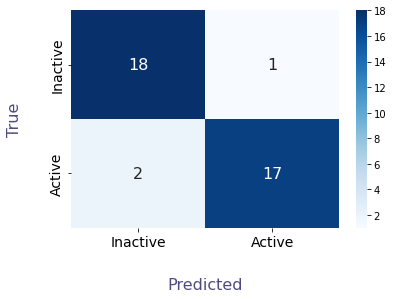

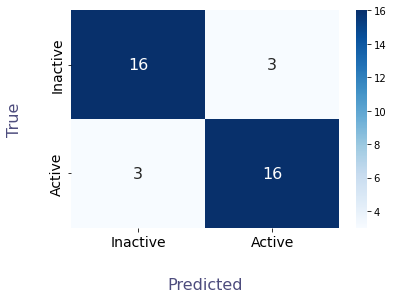

In [15]:
calculations.confusion_matrix(xgb_opt2, x1_cv_42, y_cv_42, best_threshold_range_xgb), 
calculations.confusion_matrix(xgb_opt2, x1_et_42, y_et_42, best_threshold_range_xgb)

## Scoring 

### 19 Compounds ETSET 

In [119]:
score_xgb19 = score(xgb_opt2, etset19, best_threshold_range_xgb, x1_train_42, y_train_42)
df3 = pd.concat([etset19_auc, score_xgb19], axis = 1)
df3

,AUC0-5h,score,probability
0,921.0,0,0.319270
1,3.0,1,0.554218
2,3.0,1,0.647376
3,2393.0,1,0.518371
4,616.0,1,0.772268
5,25001.0,1,0.860513
6,9105.0,1,0.784732
7,754.0,0,0.326194
8,10399.0,1,0.811754
9,135.0,0,0.260698


### 956 Compounds 

In [27]:
score_xgb956_2 = score(xgb_opt2, etset956fitpk, best_threshold_range_xgb, x1_train_42, y_train_42)
count_xgbscore2 = score_xgb956_2['score'].value_counts()
count_xgbscore2

0    757
1    199
Name: score, dtype: int64

In [28]:
scores_xgb = pd.concat([etset956fitpk_smiles, id_name, score_xgb956_2], axis = 1)
scores_xgb = scores_xgb.sort_values(['probability'], ascending = False)
scores_xgb

,SMILES,MoleculeId,score,probability
243,Fc1c(N2CCN(Cc3c(c(N)n(-c4ccc(F)cc4)n3)-c3ccccc...,Z56903079,1,0.581144
123,C(N1CCN(c2nc(-c3cnccc3)nc3c2cccc3)CC1)c1cc2c(c...,Z237483836,1,0.572355
89,Oc1c(c(-c2ccccc2)c2c(n1)cccc2)-c1nc2c(c(-c3ccc...,Z1702969146,1,0.557301
172,Fc1ccc(-c2c(NC(=O)Nc3c4c(ccc3)cccc4)cn(-c3cccc...,Z85924883,1,0.555386
107,O(c1nc(-c2ccccc2)nc2c1cccc2)c1c2c(ccc1)cccc2,Z31213359,1,0.554248
...,...,...,...,...
233,Fc1ccc(-n2c(C)nc(C(=O)N3CCC(C(=O)N4Cc5c(cccc5)...,Z306811882,0,0.340962
616,O=C(CN1C(=O)c2c(N=N1)cccc2)N1C(c2ccccc2)COc2c1...,Z65908878,0,0.340092
433,O=C(NC(c1cc2nc[nH]c2cc1)c1ccccc1)CC1C(=O)Nc2c(...,Z237721938,0,0.339375
843,O=C(C=Cc1c(-c2ccccc2)nn(-c2ccccc2)c1)N1C(C(=O)...,Z73431169,0,0.337692


# LightGBM

In [36]:
lgbm_space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 1), 
    'max_depth': hp.quniform('max_depth',3, 12, 1), 
    'num_leaves':hp.quniform('num_leaves',20, 300, 1), 
    'min_data_in_leaf':hp.quniform('min_data_in_leaf',1, 200, 1), 
    'random_state':hp.choice('random_state',[1])}

## AUCROC 

In [5]:
def lgbm_aucroc(params):
    from sklearn.metrics import roc_auc_score
    lgbm_aucroc=LGBMClassifier(n_estimators=np.int64(params['n_estimators']),
                               max_depth=np.int64(params['max_depth']),
                               num_leaves=np.int64(params['num_leaves']),
                               min_data_in_leaf=np.int64(params['min_data_in_leaf']),
                               random_state = np.int64(params['random_state']))
                               
                               
    lgbm_aucroc.fit(x1_train_42, np.ravel(y_train_42))
    rocauc = roc_auc_score(y_cv_42, lgbm_aucroc.predict_proba(x1_cv_42)[:, 1])
    score = rocauc*-1
    return score

In [149]:
tpe_algorithm = tpe.suggest
num_eval = 2000
trials = Trials()
best_param = fmin(lgbm_aucroc, lgbm_space, algo=tpe.suggest, trials=trials, max_evals=num_eval,rstate=rstate=np.random.default_rng(1))
print(best_param)

[LightGBM] [Warning]                                    
min_data_in_leaf is set=190, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=190
[LightGBM] [Warning]                                                
min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning]                                                
min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning]                                                               
min_data_in_leaf is set=154, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=154
[LightGBM] [Warning]                                                               
min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning]                                                               
min_data_in_leaf is set=6, min_child_samples=2

[LightGBM] [Warning]                                                                
min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning]                                                                
min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning]                                                                
min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning]                                                                
min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning]                                                                
min_data_in_leaf is set=135, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=135
[LightGBM] [Warning]                                                

[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning]                                                 

[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning]                                             

[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=195, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=195
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning]                                             

[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning]                                             

[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=192, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=192
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning]                                           

[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning]                                               

[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning]                                                                 
Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning]                                       

[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=186, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=186
[LightGBM] [Warning]                                             

[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning]                                             

[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning]                                                                 
min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning]                                               

[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning]                                        

[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=162, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=162
[LightGBM] [Warning]                                        

[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning]                                        

[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning]                                        

[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning]                                        

[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning]                                        

[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning]                                        

[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning]                                        

[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning]                                          

[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning]                                        

[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning]                                          

[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning]                                                                  
min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
100%|██████████| 2000/2000 [18:41<00:00,  1.78trial/s, best loss: -0.9584487534626039]
{'max_depth': 5.0, 'min_data_in_leaf': 23.0, 'n_estimators': 482.0, 'num_leaves': 156.0, 'random_state': 0}


### Results 

#### Metrics 

In [17]:
lgbm1 = LGBMClassifier(max_depth = 5, min_data_in_leaf = 23, n_estimators = 482, num_leaves = 156, random_state=1)
lgbm1.fit(x1_train_42, y_train_42)
best_threshold_range_lgbm = calculations.optimized_threshold(lgbm1, x1_cv_42, y_cv_42, 'range')
lgbm_met1_range = calculations.classification_metrics(lgbm1, x1_cv_42, y_cv_42, x1_et_42, y_et_42, best_threshold_range_lgbm)
lgbm_met1_range

[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


,CV Set,Test Set
Threshold,0.229000,0.229000
ROC AUC,0.947368,0.842105
PR AUC,0.960526,0.881579
Balanced Accuracy,0.947368,0.842105
Sensitivity,0.947368,0.842105
Specificity,0.947368,0.842105
MCC,0.894737,0.684211
Precision,0.947368,0.842105
Recall,0.947368,0.842105
F1 Score,0.947368,0.842105


####  Confusion Matrix

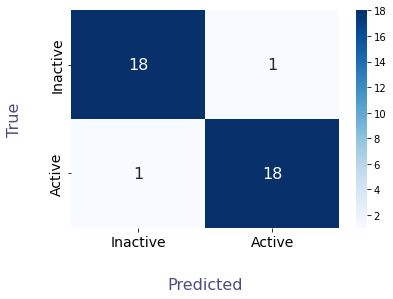

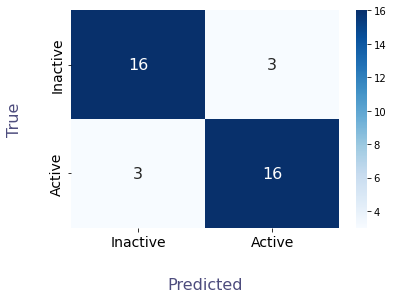

In [18]:
calculations.confusion_matrix(lgbm1, x1_cv_42, y_cv_42, best_threshold_range_lgbm),
calculations.confusion_matrix(lgbm1, x1_et_42, y_et_42, best_threshold_range_lgbm)

## Scoring 

### 19 Compounds ETSET 

In [120]:
score_lgbm19 = score(lgbm1, etset19, best_threshold_range_lgbm, x1_train_42, y_train_42)
df4 = pd.concat([etset19_auc, score_lgbm19], axis = 1)
df4

[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


,AUC0-5h,score,probability
0,921.0,0,0.319270
1,3.0,1,0.554218
2,3.0,1,0.647376
3,2393.0,1,0.518371
4,616.0,1,0.772268
5,25001.0,1,0.860513
6,9105.0,1,0.784732
7,754.0,0,0.326194
8,10399.0,1,0.811754
9,135.0,0,0.260698


### 956 Compounds 

In [32]:
score_lgbm956_2 = score(lgbm1, etset956fitpk, best_threshold_range_lgbm, x1_train_42, y_train_42)
count_lgbmscore2 = score_lgbm956_2['score'].value_counts()
count_lgbmscore2

[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


1    655
0    301
Name: score, dtype: int64

In [33]:
scores_lgbm = pd.concat([etset956fitpk_smiles,id_name, score_lgbm956_2], axis = 1)
scores_lgbm = scores_lgbm.sort_values(['probability'], ascending = False)
scores_lgbm

,SMILES,MoleculeId,score,probability
89,Oc1c(c(-c2ccccc2)c2c(n1)cccc2)-c1nc2c(c(-c3ccc...,Z1702969146,1,0.979135
558,O=C1N(c2ccc(C)cc2)C(=O)c2c(C1=CNc1sc3c(n1)-c1c...,Z31305710,1,0.961866
771,Fc1c(F)c2nc(NC(=O)c3c4c(nc(-c5ccc(C)cc5)c3)ccc...,Z27033395,1,0.961866
243,Fc1c(N2CCN(Cc3c(c(N)n(-c4ccc(F)cc4)n3)-c3ccccc...,Z56903079,1,0.953015
799,O=C(Nc1ccccc1)c1c(NC(=O)c2c3c(nc(-c4sccc4)c2)c...,Z56945956,1,0.952106
...,...,...,...,...
64,O=C(Nc1ccccc1)N1CCC(C(=O)Nc2cc(C3=NNC(=O)C=C3)...,Z952432854,0,0.001820
927,O=C(NN1C(=O)C(c2ccccc2)(c2ccccc2)NC1=O)CN1Cc2c...,Z104536186,0,0.001820
233,Fc1ccc(-n2c(C)nc(C(=O)N3CCC(C(=O)N4Cc5c(cccc5)...,Z306811882,0,0.001704
239,Fc1ccc(C=2OC(=O)N(CC(=O)c3cc4-c5c(cccc5)Cc4cc3...,Z151004596,0,0.001441


# Overall Results

## Best Models 

In [20]:
results = pd.concat((rf_metrics, xgb_opt2_range, lgbm_met1_range), axis = 1)
results.columns = pd.MultiIndex.from_tuples([('Random Forest', 'CV Set'), ('Random Forest', 'Test Set'),
                                             ('XGBoost', 'CV Set'), ('XGBoost', 'Test Set'),
                                             ('LightGBM', 'CV Set'),('LightGBM', 'Test Set')])
results

Random Forest             XGBoost            LightGBM  \
                         CV Set  Test Set    CV Set  Test Set    CV Set   
Threshold              0.349000  0.349000  0.466000  0.466000  0.229000   
ROC AUC                0.921053  0.868421  0.921053  0.842105  0.947368   
PR AUC                 0.931818  0.898684  0.945906  0.881579  0.960526   
Balanced Accuracy      0.921053  0.868421  0.921053  0.842105  0.947368   
Sensitivity            1.000000  0.894737  0.894737  0.842105  0.947368   
Specificity            0.842105  0.842105  0.947368  0.842105  0.947368   
MCC                    0.852803  0.737865  0.843274  0.684211  0.894737   
Precision              0.863636  0.850000  0.944444  0.842105  0.947368   
Recall                 1.000000  0.894737  0.894737  0.842105  0.947368   
F1 Score               0.926829  0.871795  0.918919  0.842105  0.947368   

                             
                   Test Set  
Threshold          0.229000  
ROC AUC            0.842105  
PR AUC             0.881579  
Balanced Accuracy  0.842105  
Sensitivity        0.842105  
Specificity        0.842105  
MCC                0.684211  
Precision          0.842105  
Recall             0.842105  
F1 Score           0.842105

## ETSET 19 compounds 

In [121]:
score_results = pd.concat((etset19_auc, score_rf19, score_xgb19, score_lgbm19), axis = 1)
score_results.columns = pd.MultiIndex.from_tuples([(' ', 'AUC0-5h'),('Random Forest', 'score'), ('Random Forest', 'probability'),
                                             ('XGBoost', 'score'), ('XGBoost', 'probability'),
                                             ('LightGBM', 'score'),('LightGBM', 'probability')])
score_results

Random Forest             XGBoost             LightGBM            
    AUC0-5h         score probability   score probability    score probability
0     921.0             1    0.484848       0    0.319270        0    0.020192
1       3.0             1    0.409091       1    0.554218        1    0.976577
2       3.0             1    0.378788       1    0.647376        1    0.984446
3    2393.0             1    0.409091       1    0.518371        1    0.292928
4     616.0             1    0.545455       1    0.772268        1    0.996641
5   25001.0             1    0.545455       1    0.860513        1    0.999843
6    9105.0             1    0.454545       1    0.784732        1    0.999461
7     754.0             1    0.545455       0    0.326194        0    0.131047
8   10399.0             1    0.454545       1    0.811754        1    0.999501
9     135.0             1    0.500000       0    0.260698        0    0.016673
10   1683.0             1    0.500000       0    0.434512        0    0.131379
11   5622.0             1    0.560606       1    0.865899        1    0.999881
12   2935.0             1    0.560606       1    0.868628        1    0.999890
13   3845.5             1    0.484848       1    0.536236        1    0.812515
14  10936.0             1    0.454545       1    0.499978        1    0.812515
15   6529.0             1    0.469697       1    0.582008        1    0.797127
16   2622.0             1    0.530303       1    0.768631        1    0.999936
17   4109.0             1    0.545455       1    0.745191        1    0.999931
18   7730.0             1    0.500000       1    0.535908        1    0.921650

## ETSET 956 compounds 

In [41]:
score_results956_2 = pd.concat((count_rfscore2, count_xgbscore2, count_lgbmscore2), axis = 1)
score_results956_2.columns = pd.MultiIndex.from_tuples([('RF', 'score'), ('XGB', 'score'), ('LGBM', 'score')])
score_results956_2

,RF,XGB,LGBM
,score,score,score
0,644,757,301
1,312,199,655
